# Predicting Baseball Stats

## Preparing Environment

In [1]:
#load important libraries
import numpy as np
import pandas as pd
import pandas_profiling
import datetime
import math as m

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML libraries
import os
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split

# styling
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')
sns.set_context('talk')

## Reading in File

In [2]:
bat_df = pd.read_csv("stats.csv")
bat_df.head()

,last_name,first_name,year,player_age,b_total_pa,b_total_hits,b_double,b_triple,b_home_run,b_strikeout,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,Unnamed: 78
0,Anderson,Brian,2020,27,229,51,7,1,11,66,...,23.0,135.0,63.8,48.9,21.5,26.7,0.0,4.56,26.4,NaN
1,Encarnacion,Edwin,2020,37,181,25,5,0,10,54,...,17.9,106.0,59.7,34.0,25.5,24.5,0.0,4.79,25.6,NaN
2,Yastrzemski,Mike,2020,30,225,57,14,4,10,55,...,20.4,137.0,60.4,38.7,19.7,30.7,0.0,4.34,27.5,NaN
3,Marte,Ketel,2020,27,195,52,14,1,2,21,...,23.3,163.0,60.0,46.6,17.8,27.6,2.0,4.31,27.7,NaN
4,Soler,Jorge,2020,28,174,34,8,0,8,60,...,22.2,90.0,55.7,37.8,20.0,32.2,0.0,4.71,26.5,NaN


## EDA

In [3]:
# # Profiling
# import warnings 
# warnings.filterwarnings('ignore')

# report = pandas_profiling.ProfileReport(bat_df)
# report

In [4]:
bat_df.shape

(3882, 79)

In [5]:
bat_df.columns

Index(['last_name', ' first_name', 'year', 'player_age', 'b_total_pa',
       'b_total_hits', 'b_double', 'b_triple', 'b_home_run', 'b_strikeout',
       'b_walk', 'batting_avg', 'on_base_plus_slg', 'isolated_power', 'b_rbi',
       'b_lob', 'r_total_caught_stealing', 'r_total_stolen_base', 'r_run',
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed

In [6]:
bat_df.rename(columns={'player_age':'age','b_total_pa':'pa','b_total_hits':'hits',
                                'b_double':'doubles','b_triple':'triples','b_home_run':'hr',
                                'b_strikeout':'so','b_walk':'bb','batting_avg':'avg',
                                'on_base_plus_slg':'ops','b_rbi':'rbi','r_run':'runs',
                                'r_total_stolen_base':'sb'},inplace=True)

In [7]:
bat_df = bat_df.drop('Unnamed: 78', axis='columns')

In [8]:
no_nulls = bat_df.isna().sum()
no_nulls[no_nulls > 0]

xba                       1355
xslg                      1355
woba                      1355
xwoba                     1355
xobp                      1355
xiso                      1355
wobacon                   1355
xwobacon                  1355
bacon                     1355
xbacon                    1355
xbadiff                   1355
exit_velocity_avg         1355
launch_angle_avg          1355
sweet_spot_percent        1355
barrels                   1355
barrel_batted_rate        1355
solidcontact_percent      1355
flareburner_percent       1355
poorlyunder_percent       1355
poorlytopped_percent      1355
poorlyweak_percent        1355
hard_hit_percent          1355
z_swing_percent           1355
z_swing_miss_percent      1355
oz_swing_percent          1355
oz_swing_miss_percent     1355
oz_contact_percent        1355
out_zone_swing_miss       1355
out_zone_swing            1355
out_zone_percent          1355
out_zone                  1355
meatball_swing_percent    1355
meatball

1355 players do not have data collected due to low number of at-bats I presume. We can drop those rows since only statcats can predict those stats. 

In [9]:
bat_df = bat_df.dropna(subset=['xba', 'xslg', 'woba', 'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'sprint_speed',])

In [10]:
no_nulls = bat_df.isna().sum()
no_nulls[no_nulls > 0]

hp_to_1b    918
dtype: int64

Perfect, only home plate to first base (hp_to_1b) is remaining to impute now. We lost 1355 rows but they were useless since Statcast data has most of the predictive power.

### Imputing hp_to_1b

In [11]:
median_speed_groups = bat_df.groupby(["sprint_speed"])["hp_to_1b"].median()
median_speed_groups

sprint_speed
21.9    5.11
22.0     NaN
22.2    5.02
22.4     NaN
22.5    5.02
        ... 
30.3    4.04
30.4    4.05
30.5    3.95
30.8    3.94
30.9     NaN
Name: hp_to_1b, Length: 87, dtype: float64

In [12]:
median_speed_groups = median_speed_groups.fillna(method='ffill')

In [13]:
median_speed_groups

sprint_speed
21.9    5.11
22.0    5.11
22.2    5.02
22.4    5.02
22.5    5.02
        ... 
30.3    4.04
30.4    4.05
30.5    3.95
30.8    3.94
30.9    3.94
Name: hp_to_1b, Length: 87, dtype: float64

In [14]:
median_speed_groups.isnull().sum()

0

In [15]:
# We do a .merge to "expand" our groups to fit the original dataset
median_speed_groups.name = "Inferred_hp_to_1b"  # For clarity
median_speed_groups = (
     bat_df[["sprint_speed"]]  # Select only the columns we are interested in
    .merge(
        median_speed_groups,
        left_on=["sprint_speed"],
        right_index=True
    ).sort_index()  # For better display
)
median_speed_groups.head()

,sprint_speed,Inferred_hp_to_1b
0,26.4,4.490
1,25.6,4.600
2,27.5,4.340
3,27.7,4.310
4,26.5,4.505


In [16]:
# Indexes are aligned, pandas does the magic!
bat_df.loc[bat_df["hp_to_1b"].isnull(), "hp_to_1b"] = median_speed_groups["Inferred_hp_to_1b"]

In [17]:
no_nulls = bat_df.isna().sum()
no_nulls[no_nulls > 0]

Series([], dtype: int64)

In [18]:
bat_df.head()

,last_name,first_name,year,age,pa,hits,doubles,triples,hr,so,...,straightaway_percent,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed
0,Anderson,Brian,2020,27,229,51,7,1,11,66,...,34.1,23.0,135.0,63.8,48.9,21.5,26.7,0.0,4.56,26.4
1,Encarnacion,Edwin,2020,37,181,25,5,0,10,54,...,36.8,17.9,106.0,59.7,34.0,25.5,24.5,0.0,4.79,25.6
2,Yastrzemski,Mike,2020,30,225,57,14,4,10,55,...,39.4,20.4,137.0,60.4,38.7,19.7,30.7,0.0,4.34,27.5
3,Marte,Ketel,2020,27,195,52,14,1,2,21,...,40.5,23.3,163.0,60.0,46.6,17.8,27.6,2.0,4.31,27.7
4,Soler,Jorge,2020,28,174,34,8,0,8,60,...,28.9,22.2,90.0,55.7,37.8,20.0,32.2,0.0,4.71,26.5


In [19]:
bat_df.shape

(2527, 78)

### Fix 2020 - multiply absolute value stats by 2.66 (160/60 games)

In [20]:
abs_val_stats = ['pa','hits','doubles','triples', 'hr', 'so', 'bb','sb', 'runs',
       'b_total_swinging_strike', 'r_total_pickoff','barrels','out_zone_swing_miss',
       'out_zone_swing','out_zone','pitch_count_offspeed','pitch_count_fastball', 
        'pitch_count_breaking', 'pitch_count','in_zone','in_zone_swing','edge','batted_ball','n_bolts']

In [21]:
bat_df.loc[bat_df["year"] == 2020, abs_val_stats] *= 2.66

In [22]:
bat_df.loc[bat_df["year"] == 2020,:]

,last_name,first_name,year,age,pa,hits,doubles,triples,hr,so,...,straightaway_percent,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed
0,Anderson,Brian,2020,27,609.14,135.66,18.62,2.66,29.26,175.56,...,34.1,23.0,359.10,63.8,48.9,21.5,26.7,0.00,4.56,26.4
1,Encarnacion,Edwin,2020,37,481.46,66.50,13.30,0.00,26.60,143.64,...,36.8,17.9,281.96,59.7,34.0,25.5,24.5,0.00,4.79,25.6
2,Yastrzemski,Mike,2020,30,598.50,151.62,37.24,10.64,26.60,146.30,...,39.4,20.4,364.42,60.4,38.7,19.7,30.7,0.00,4.34,27.5
3,Marte,Ketel,2020,27,518.70,138.32,37.24,2.66,5.32,55.86,...,40.5,23.3,433.58,60.0,46.6,17.8,27.6,5.32,4.31,27.7
4,Soler,Jorge,2020,28,462.84,90.44,21.28,0.00,21.28,159.60,...,28.9,22.2,239.40,55.7,37.8,20.0,32.2,0.00,4.71,26.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Martinez,J.D.,2020,33,630.42,119.70,42.56,0.00,18.62,156.94,...,40.9,24.0,409.64,61.2,35.1,28.6,33.8,0.00,4.73,25.9
306,Abreu,Jose,2020,33,696.92,202.16,39.90,0.00,50.54,156.94,...,41.2,24.7,484.12,59.2,45.1,19.2,31.3,0.00,4.62,26.8
307,Brinson,Lewis,2020,26,297.92,63.84,15.96,0.00,7.98,79.80,...,42.1,11.8,202.16,67.0,50.0,18.4,25.0,5.32,4.31,28.6
308,Altuve,Jose,2020,30,558.60,111.72,23.94,0.00,13.30,103.74,...,36.6,24.8,406.98,67.1,51.0,20.3,22.2,47.88,4.22,28.4


## Feature Engineering

### XBH

In [23]:
bat_df["xbh"] = bat_df["doubles"] + bat_df["triples"] + bat_df["hr"]

In [24]:
bat_df.tail()

,last_name,first_name,year,age,pa,hits,doubles,triples,hr,so,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,xbh
3424,Benintendi,Andrew,2016,22,118.0,31.0,11.0,1.0,2.0,25.0,...,28.0,82.0,61.9,36.6,25.6,29.3,1.0,4.22,28.6,14.0
3425,Kemp,Tony,2016,25,136.0,26.0,4.0,3.0,1.0,27.0,...,26.3,95.0,61.8,48.4,22.1,24.2,0.0,4.31,27.7,8.0
3426,White,Tyler,2016,26,276.0,54.0,16.0,0.0,8.0,65.0,...,29.6,186.0,55.8,43.0,22.0,23.1,0.0,4.47,26.9,24.0
3427,Diaz,Aledmys,2016,26,460.0,121.0,28.0,3.0,17.0,60.0,...,21.9,352.0,58.0,46.9,24.4,20.7,22.0,4.19,29.1,48.0
3428,Park,ByungHo,2016,30,244.0,41.0,9.0,1.0,12.0,80.0,...,21.0,138.0,52.5,41.3,32.6,17.4,0.0,4.43,26.7,22.0


### Injured

4 Levels:

0. Not injured
1. Slightly injured
2. Half season Injured
3. Seriously Injured

In [25]:
bat_df = bat_df.reset_index()

In [26]:
bat_df = bat_df.drop("index",axis=1)

In [27]:
L = []
for i in bat_df["pa"]:
    if i < 200:
        L.append(3)
    elif i < 300:
        L.append(2)
    elif i < 400:
        L.append(1)
    else: 
        L.append(0)

bat_df["injured"] = pd.Series(L)

In [28]:
bat_df.loc[:,["pa","injured"]]

,pa,injured
0,609.14,0
1,481.46,0
2,598.50,0
3,518.70,0
4,462.84,0
...,...,...
2522,118.00,3
2523,136.00,3
2524,276.00,2
2525,460.00,0


In [29]:
bat_df["injured"].isnull().sum()

0

In [30]:
# import warnings 
# warnings.filterwarnings('ignore')

# report = pandas_profiling.ProfileReport(bat_df[["injured","pa"]])
# report

### Normalize absolute stats to 600 plate appereances

In [31]:
bat_df_norm = bat_df.copy()

In [32]:
for i, r in bat_df_norm.iterrows():
    bat_df_norm.loc[i, abs_val_stats] *= (600 / bat_df_norm.loc[i,"pa"])

In [33]:
bat_df.tail()

,last_name,first_name,year,age,pa,hits,doubles,triples,hr,so,...,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,xbh,injured
2522,Benintendi,Andrew,2016,22,118.0,31.0,11.0,1.0,2.0,25.0,...,82.0,61.9,36.6,25.6,29.3,1.0,4.22,28.6,14.0,3
2523,Kemp,Tony,2016,25,136.0,26.0,4.0,3.0,1.0,27.0,...,95.0,61.8,48.4,22.1,24.2,0.0,4.31,27.7,8.0,3
2524,White,Tyler,2016,26,276.0,54.0,16.0,0.0,8.0,65.0,...,186.0,55.8,43.0,22.0,23.1,0.0,4.47,26.9,24.0,2
2525,Diaz,Aledmys,2016,26,460.0,121.0,28.0,3.0,17.0,60.0,...,352.0,58.0,46.9,24.4,20.7,22.0,4.19,29.1,48.0,0
2526,Park,ByungHo,2016,30,244.0,41.0,9.0,1.0,12.0,80.0,...,138.0,52.5,41.3,32.6,17.4,0.0,4.43,26.7,22.0,2


In [34]:
bat_df_norm.tail()

,last_name,first_name,year,age,pa,hits,doubles,triples,hr,so,...,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,xbh,injured
2522,Benintendi,Andrew,2016,22,600.0,157.627119,55.932203,5.084746,10.169492,127.118644,...,416.949153,61.9,36.6,25.6,29.3,5.084746,4.22,28.6,14.0,3
2523,Kemp,Tony,2016,25,600.0,114.705882,17.647059,13.235294,4.411765,119.117647,...,419.117647,61.8,48.4,22.1,24.2,0.000000,4.31,27.7,8.0,3
2524,White,Tyler,2016,26,600.0,117.391304,34.782609,0.000000,17.391304,141.304348,...,404.347826,55.8,43.0,22.0,23.1,0.000000,4.47,26.9,24.0,2
2525,Diaz,Aledmys,2016,26,600.0,157.826087,36.521739,3.913043,22.173913,78.260870,...,459.130435,58.0,46.9,24.4,20.7,28.695652,4.19,29.1,48.0,0
2526,Park,ByungHo,2016,30,600.0,100.819672,22.131148,2.459016,29.508197,196.721311,...,339.344262,52.5,41.3,32.6,17.4,0.000000,4.43,26.7,22.0,2


### Unite first and last name to make index for predicting

In [35]:
bat_df["name"] = bat_df["last_name"].str.cat(bat_df[" first_name"], sep=' ')

In [36]:
bat_df = bat_df.drop(["last_name"," first_name"],axis=1)
bat_df.head()

,year,age,pa,hits,doubles,triples,hr,so,bb,avg,...,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,xbh,injured,name
0,2020,27,609.14,135.66,18.62,2.66,29.26,175.56,58.52,0.255,...,63.8,48.9,21.5,26.7,0.00,4.56,26.4,50.54,0,Anderson Brian
1,2020,37,481.46,66.50,13.30,0.00,26.60,143.64,42.56,0.157,...,59.7,34.0,25.5,24.5,0.00,4.79,25.6,39.90,0,Encarnacion Edwin
2,2020,30,598.50,151.62,37.24,10.64,26.60,146.30,79.80,0.297,...,60.4,38.7,19.7,30.7,0.00,4.34,27.5,74.48,0,Yastrzemski Mike
3,2020,27,518.70,138.32,37.24,2.66,5.32,55.86,18.62,0.287,...,60.0,46.6,17.8,27.6,5.32,4.31,27.7,45.22,0,Marte Ketel
4,2020,28,462.84,90.44,21.28,0.00,21.28,159.60,50.54,0.228,...,55.7,37.8,20.0,32.2,0.00,4.71,26.5,42.56,0,Soler Jorge


### Unite first and last name to make index for predicting bat_df_norm

In [37]:
bat_df_norm["name"] = bat_df_norm["last_name"].str.cat(bat_df_norm[" first_name"], sep=' ')

In [38]:
bat_df_norm = bat_df_norm.drop(["last_name"," first_name"],axis=1)
bat_df_norm.head()

,year,age,pa,hits,doubles,triples,hr,so,bb,avg,...,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,xbh,injured,name
0,2020,27,600.0,133.624454,18.340611,2.620087,28.820961,172.925764,57.641921,0.255,...,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,50.54,0,Anderson Brian
1,2020,37,600.0,82.872928,16.574586,0.000000,33.149171,179.005525,53.038674,0.157,...,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,39.90,0,Encarnacion Edwin
2,2020,30,600.0,152.000000,37.333333,10.666667,26.666667,146.666667,80.000000,0.297,...,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,74.48,0,Yastrzemski Mike
3,2020,27,600.0,160.000000,43.076923,3.076923,6.153846,64.615385,21.538462,0.287,...,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,45.22,0,Marte Ketel
4,2020,28,600.0,117.241379,27.586207,0.000000,27.586207,206.896552,65.517241,0.228,...,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,42.56,0,Soler Jorge


## EDA

### Age vs. Injured

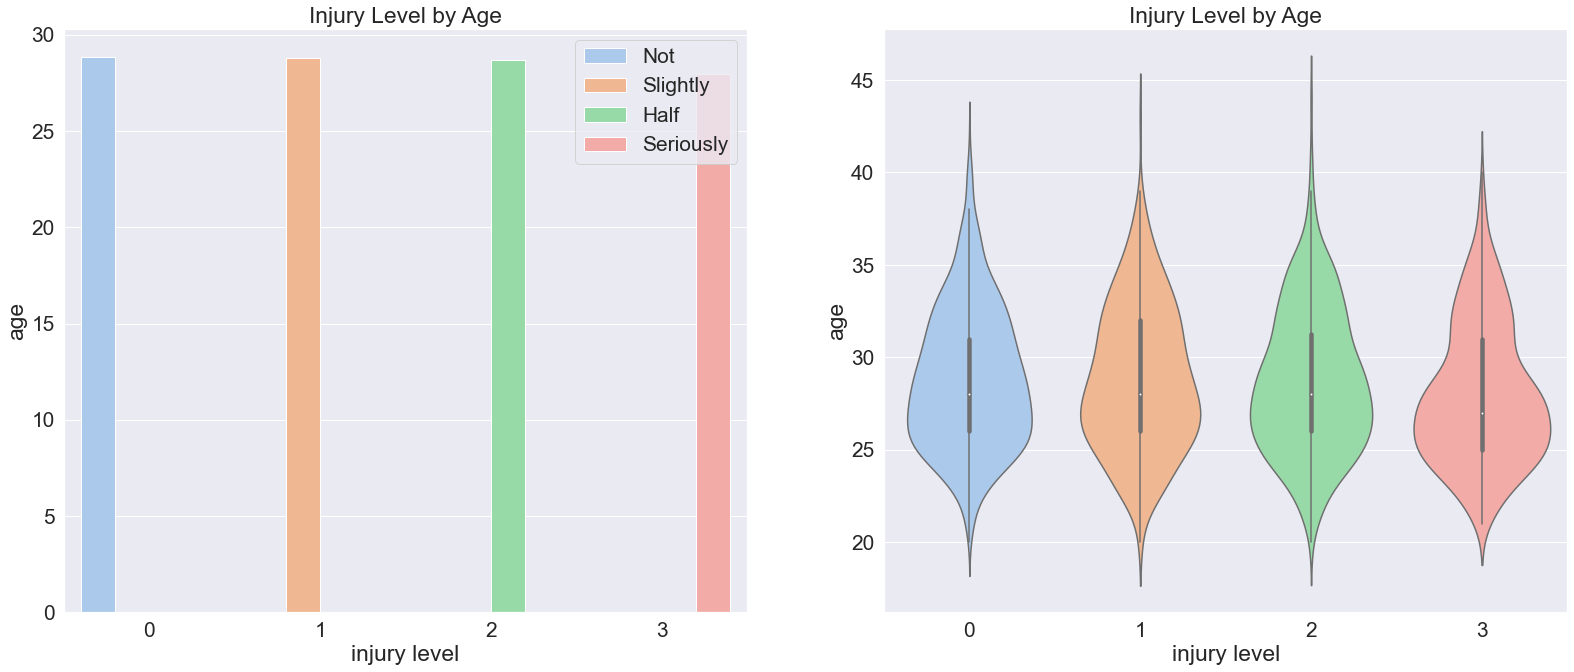

In [44]:
# setting graph frame
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24,10))

# creating barplot to get the bikes rent per season
ax1 = sns.barplot(bat_df['injured'].astype(int), bat_df['age'], hue='injured', data=bat_df, palette='pastel', ci=None, ax=ax1,);
ax2 = sns.violinplot(bat_df['injured'].astype(int), 'age', data=bat_df, palette='pastel', ax=ax2,);

# labelling graph
ax1.set(xlabel='injury level', ylabel='age', title='Injury Level by Age', label='big',);
ax2.set(xlabel='injury level', ylabel='age', title='Injury Level by Age', label='big',);
sns.set(font_scale = 1.9)

# renaming seasons
ax1.legend(labels=["Not", "Slightly", "Half", "Seriously"]);

### Age vs. Speed

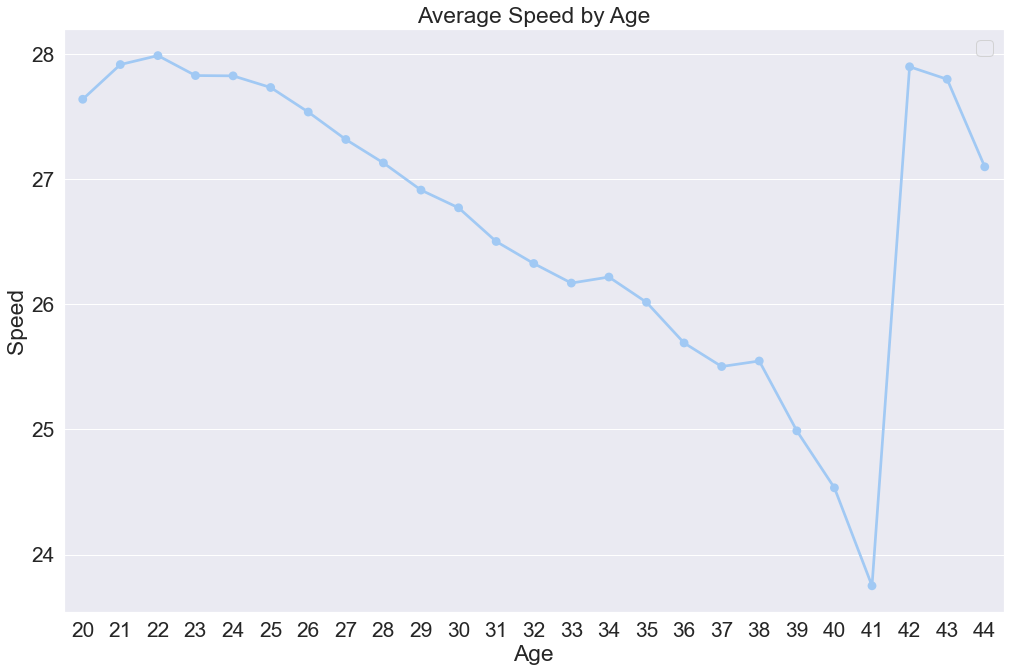

In [52]:
plt.figure(figsize=(15, 10),)
sns.set_palette('pastel')

age = pd.DataFrame(bat_df.groupby(["age"], sort=True)["sprint_speed"].mean()).reset_index();
ax = sns.pointplot(x=age["age"].astype(int), y=age["sprint_speed"], data=age);
ax.set(xlabel='Age', ylabel='Speed', title="Average Speed by Age", label='big',);

# renaming workingdays
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]);

### Age vs. Isolated Power

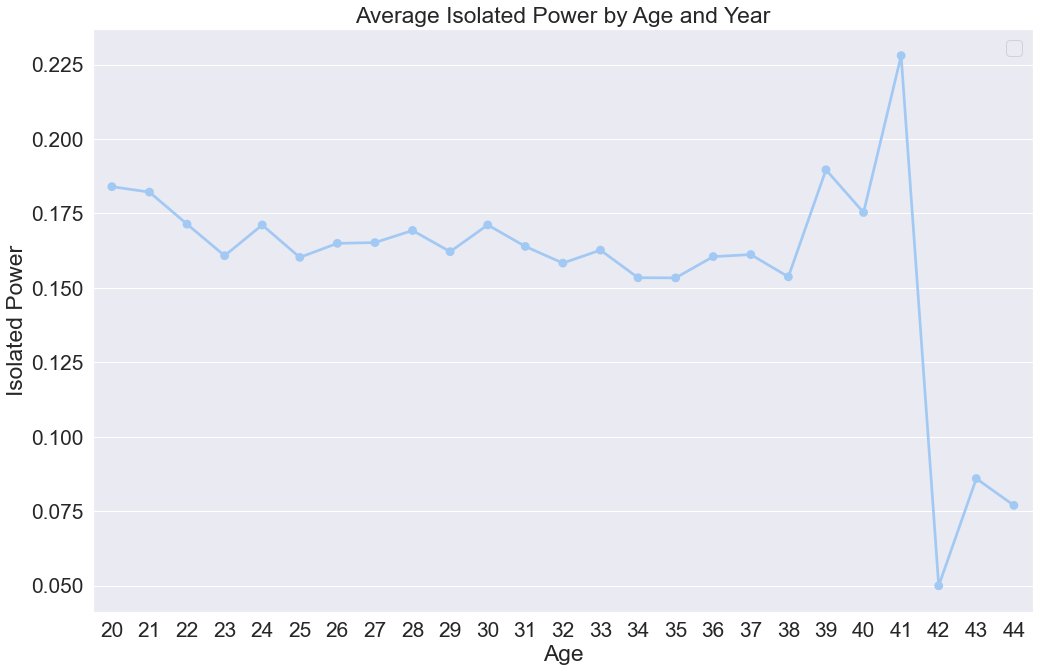

In [51]:
plt.figure(figsize=(15, 10),)
sns.set_palette('pastel')

age = pd.DataFrame(bat_df.groupby(["age"], sort=True)["isolated_power"].mean()).reset_index();
ax = sns.pointplot(x=age["age"].astype(int), y=age["isolated_power"], data=age);
ax.set(xlabel='Age', ylabel='Isolated Power', title="Average Isolated Power by Age and Year", label='big',);

# renaming workingdays
leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles, ["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]);

In [61]:
bat_df.loc[bat_df["age"]>=42,["last_name"," first_name","isolated_power","sprint_speed","year","age"]]

,last_name,first_name,isolated_power,sprint_speed,year,age
313,Suzuki,Ichiro,0.077,27.1,2017,44
1656,Suzuki,Ichiro,0.050,27.9,2015,42
2097,Suzuki,Ichiro,0.086,27.8,2016,43


I guess Ichiro breaks the rules

## Setting up Stats

In [39]:
names_df = pd.DataFrame(bat_df.loc[bat_df["year"]==2019,"name"])

In [40]:
names_df = names_df.reset_index()

In [41]:
names_df = names_df.drop("index",axis=1)
names_df

,name
0,Pujols Albert
1,Cabrera Miguel
2,Mathis Jeff
3,Choo Shin-Soo
4,Molina Yadier
...,...
446,Smith Will
447,Hiura Keston
448,Lopez Nicky
449,Alvarez Yordan


Machine Learning Necesarry Libraries

In [42]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

#import libraries
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Plate Appereances

In [285]:
pa_df = bat_df[['name','year', 'age','isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','pa']]
pa_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,pa
0,Anderson Brian,2020,27,0.210,81,0,1159.76,0.0,0.228,0.425,...,23.0,359.10,63.8,48.9,21.5,26.7,0.00,4.56,26.4,609.14
1,Encarnacion Edwin,2020,37,0.220,86,0,962.92,0.0,0.164,0.369,...,17.9,281.96,59.7,34.0,25.5,24.5,0.00,4.79,25.6,481.46
2,Yastrzemski Mike,2020,30,0.271,63,1,978.88,0.0,0.255,0.496,...,20.4,364.42,60.4,38.7,19.7,30.7,0.00,4.34,27.5,598.50
3,Marte Ketel,2020,27,0.122,54,0,832.58,0.0,0.265,0.379,...,23.3,433.58,60.0,46.6,17.8,27.6,5.32,4.31,27.7,518.70
4,Soler Jorge,2020,28,0.215,46,0,750.12,0.0,0.244,0.490,...,22.2,239.40,55.7,37.8,20.0,32.2,0.00,4.71,26.5,462.84


Lets see the distributions first

## Train-Test (X,y) Splitting

In [314]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_pa = pa_df.loc[pa_df["year"]<2019,:].drop(columns=["pa", "year","name"])
y_train_pa = pa_df.loc[pa_df["year"]<2019,"pa"] #target column

X_test_pa = pa_df.loc[pa_df["year"]==2019,:].drop(columns=["pa", "year","name"])
y_test_pa = pa_df.loc[pa_df["year"]==2019,"pa"] #target column

## Feature Importance

In [290]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_pa, y_train_pa)

RandomForestRegressor()

In [291]:
#sort the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_pa.columns,)
rf_important.sort_values(ascending=False)

pitch_count                0.944018
b_total_swinging_strike    0.030315
batted_ball                0.013712
in_zone                    0.004130
in_zone_swing              0.002739
                             ...   
barrels                    0.000028
n_bolts                    0.000028
barrel_batted_rate         0.000026
xiso                       0.000025
r_total_pickoff            0.000023
Length: 63, dtype: float64

In [ ]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_pa.columns, rf_important);
plt.title("Feature Importance with RandomForestRegressor")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [276]:
#import libraries
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [48]:
pipe = Pipeline([
        ('RF', print("AVG RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegressor
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_pa, y_train_pa, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegressor
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_pa, y_train_pa, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

AVG RF R2 of the 5 folds = 0.957030493944244
AVG XGboost R2 of the 5 folds = 0.9695525067615381


### XGBoost without PCA

In [277]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_pa, y_train_pa)
print("Randomized Search Finished")

Randomized Search Finished


In [278]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7964900909998309,
                              gamma=0.4788203131093869, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.03985310049603216,
                              max_delta_step=0, max_depth=4, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=446, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.7921439580379904,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [292]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.7964900909998309, 
                               gamma = 0.4788203131093869, 
                               learning_rate = 0.03985310049603216, 
                               max_depth = 4, 
                               n_estimators = 446, 
                               subsample = 0.7921439580379904, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_pa,y_train_pa)

XG_pa_predictions = XGboost.predict(X_test_pa)

In [293]:
r2_score_xgboost = r2_score(y_test_pa, 
                             XG_pa_predictions)
r2_score_xgboost

0.9966556749828324

In [284]:
X_test_pa.head()

,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,woba,xwoba,...,n_bolts,hp_to_1b,sprint_speed,hits,hr,rbi,runs,so,bb,xbh
745,39,0.185,223,0,928.0,1.0,0.253,0.433,0.308,0.322,...,0.0,5.02,22.5,120.0,23.0,93,55.0,68.0,43.0,45.0
746,36,0.116,165,0,1008.0,1.0,0.272,0.443,0.318,0.336,...,0.0,4.95,23.5,139.0,12.0,59,41.0,108.0,48.0,33.0
747,36,0.066,78,0,488.0,0.0,0.163,0.225,0.190,0.196,...,0.0,4.61,25.8,36.0,2.0,12,17.0,87.0,15.0,11.0
748,37,0.190,180,1,1149.0,1.0,0.266,0.480,0.353,0.365,...,0.0,4.35,26.6,149.0,24.0,61,93.0,165.0,78.0,57.0
749,37,0.129,171,0,903.0,0.0,0.273,0.444,0.303,0.328,...,0.0,4.93,22.8,113.0,10.0,57,45.0,58.0,23.0,34.0


### XGBoost with PCA

In [294]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_pa, y_train_pa)
print("Randomized Search Finished")

Randomized Search Finished


In [295]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9335501855257048,
                              gamma=0.04610480244708709, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.07043839187799152,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=257, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.6492230024655973,
                              tree_method='exact', validate_parameters=1,
                              verbo

In [305]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.9335501855257048, 
                               gamma = 0.04610480244708709, 
                               learning_rate = 0.07043839187799152, 
                               max_depth = 3, 
                               n_estimators = 257, 
                               subsample = 0.6492230024655973, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_pa,y_train_pa)

PCA_pa_predictions = XGboost_PCA.predict(X_test_pa)

In [306]:
r2_score_xgboost = r2_score(y_test_pa, 
                             PCA_pa_predictions)
r2_score_xgboost

0.9965276934607966

### Export your best model

In [307]:
PCA_pa_predictions = pd.DataFrame(PCA_pa_predictions)

In [308]:
PCA_pa_predictions = PCA_pa_predictions.join(names_df, how="inner")

In [309]:
PCA_pa_predictions = PCA_pa_predictions.pivot_table(index="name")
PCA_pa_predictions.head()

,0
name,
Abreu Jose,695.422119
Acuna Jr. Ronald,705.813477
Adames Willy,582.343689
Adams Matt,326.317535
Adrianza Ehire,224.083466


In [310]:
XG_pa_predictions = pd.DataFrame(XG_pa_predictions)

In [311]:
XG_pa_predictions = XG_pa_predictions.join(names_df, how="inner")

In [312]:
XG_pa_predictions = XG_pa_predictions.pivot_table(index="name")
XG_pa_predictions.head()

,0
name,
Abreu Jose,698.750244
Acuna Jr. Ronald,707.539734
Adames Willy,585.217285
Adams Matt,332.380280
Adrianza Ehire,226.652328


In [313]:
PCA_pa_predictions.to_csv("pa.csv")

In [ ]:
XGB_pa_predictions.to_csv("pa.csv")

# Hits

In [398]:
hits_df = bat_df_norm[['name','year', 'age','isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','hits']]
hits_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,hits
0,Anderson Brian,2020,27,0.210,81,0,1142.358079,0.0,0.228,0.425,...,23.0,353.711790,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,133.624454
1,Encarnacion Edwin,2020,37,0.220,86,0,1200.000000,0.0,0.164,0.369,...,17.9,351.381215,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,82.872928
2,Yastrzemski Mike,2020,30,0.271,63,1,981.333333,0.0,0.255,0.496,...,20.4,365.333333,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,152.000000
3,Marte Ketel,2020,27,0.122,54,0,963.076923,0.0,0.265,0.379,...,23.3,501.538462,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,160.000000
4,Soler Jorge,2020,28,0.215,46,0,972.413793,0.0,0.244,0.490,...,22.2,310.344828,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,117.241379


Lets see the distributions first

In [153]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Average rating of apps
avg_hits = hits_df["hits"].mean(skipna=True)
print('Average app rating = ', avg_hits)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = hits_df['hits']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_hits,
              'y0': 0,
              'x1': avg_hits,
              'y1': 150,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  134.9569348854564


## Train-Test (X,y) Splitting

In [399]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_hits = hits_df.loc[hits_df["year"]<2019,:].drop(columns=["hits", "year","name"])
y_train_hits = hits_df.loc[hits_df["year"]<2019,"hits"] #target column

X_test_hits = hits_df.loc[hits_df["year"]==2019,:].drop(columns=["hits", "year","name"])
y_test_hits = hits_df.loc[hits_df["year"]==2019,"hits"] #target column

In [400]:
names_df = pd.DataFrame(hits_df.loc[hits_df["year"]==2019,"name"])

In [401]:
names_df = names_df.reset_index()

In [402]:
names_df = names_df.drop("index",axis=1)
names_df.head()

,name
0,Pujols Albert
1,Cabrera Miguel
2,Mathis Jeff
3,Choo Shin-Soo
4,Molina Yadier


## Feature Importance

In [39]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_hits, y_train_hits)

RandomForestRegressor()

In [40]:
#sort the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_hits.columns,)
rf_important.sort_values(ascending=False)

xba                   0.590999
xbadiff               0.316975
xobp                  0.013888
bacon                 0.013188
batted_ball           0.011447
                        ...   
xiso                  0.000331
xslg                  0.000326
barrels               0.000295
barrel_batted_rate    0.000250
xwobacon              0.000223
Length: 63, dtype: float64

In [ ]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_hits.columns, rf_important);
plt.title("Feature Importance with RandomForestRegressor")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [41]:
#import libraries
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost
from sklearn import svm
from sklearn.svm import SVR
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [48]:
pipe = Pipeline([
        ('RF', print("AVG RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegressor
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_hits, y_train_hits, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegressor
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_hits, y_train_hits, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

AVG RF R2 of the 5 folds = 0.957030493944244
AVG XGboost R2 of the 5 folds = 0.9695525067615381


### XGBoost without PCA

In [403]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_hits, y_train_hits)
print("Randomized Search Finished")

Randomized Search Finished


In [404]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7120223602928729,
                              gamma=0.009240631908025987, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.13704997514866613,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=499, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.8770352449441994,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [405]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.7120223602928729, 
                               gamma = 0.009240631908025987, 
                               learning_rate = 0.13704997514866613, 
                               max_depth = 2, 
                               n_estimators = 499, 
                               subsample = 0.8770352449441994, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_hits,y_train_hits)

XG_hits_predictions = XGboost.predict(X_test_hits)

In [406]:
r2_score_xgboost = r2_score(y_test_hits, 
                             XG_hits_predictions)
r2_score_xgboost

0.9868021738053516

### XGBoost with PCA

In [407]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_hits, y_train_hits)
print("Randomized Search Finished")

Randomized Search Finished


In [408]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7214566546412373,
                              gamma=0.2492530238654525, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.21517751881388622,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=325, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.33588331985207615,
                              tree_method='exact', validate_parameters=1,
                              verbo

In [409]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.7214566546412373, 
                               gamma = 0.2492530238654525, 
                               learning_rate = 0.21517751881388622, 
                               max_depth = 2, 
                               n_estimators = 325, 
                               subsample = 0.33588331985207615, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_hits,y_train_hits)

PCA_hits_predictions = XGboost_PCA.predict(X_test_hits)

In [410]:
r2_score_xgboost = r2_score(y_test_hits, 
                             PCA_hits_predictions)
r2_score_xgboost

0.9779665339145425

### Export your best model

In [411]:
PCA_hits_predictions = pd.DataFrame(PCA_hits_predictions)

In [412]:
PCA_hits_predictions = PCA_hits_predictions.join(names_df, how="inner")

In [413]:
PCA_hits_predictions = PCA_hits_predictions.pivot_table(index="name")
PCA_hits_predictions.head()

,0
name,
Abreu Jose,155.511856
Acuna Jr. Ronald,144.701233
Adames Willy,139.559799
Adams Matt,123.031746
Adrianza Ehire,141.979065


In [414]:
XG_hits_predictions = pd.DataFrame(XG_hits_predictions)

In [415]:
XG_hits_predictions = XG_hits_predictions.join(names_df, how="inner")

In [416]:
XG_hits_predictions = XG_hits_predictions.pivot_table(index="name")
XG_hits_predictions.head()

,0
name,
Abreu Jose,155.479950
Acuna Jr. Ronald,144.297745
Adames Willy,139.004257
Adams Matt,124.249992
Adrianza Ehire,143.607788


In [ ]:
XGB_hits_predictions.to_csv("hits.csv")

Lets use the PCA one, I like the results more and it seems to be overfitting less.

In [417]:
PCA_hits_predictions.to_csv("hits.csv")

# HomeRun

In [418]:
hr_df = bat_df_norm[['name','year', 'age', 'isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','hr']]
hr_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,hr
0,Anderson Brian,2020,27,0.210,81,0,1142.358079,0.0,0.228,0.425,...,23.0,353.711790,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,28.820961
1,Encarnacion Edwin,2020,37,0.220,86,0,1200.000000,0.0,0.164,0.369,...,17.9,351.381215,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,33.149171
2,Yastrzemski Mike,2020,30,0.271,63,1,981.333333,0.0,0.255,0.496,...,20.4,365.333333,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,26.666667
3,Marte Ketel,2020,27,0.122,54,0,963.076923,0.0,0.265,0.379,...,23.3,501.538462,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,6.153846
4,Soler Jorge,2020,28,0.215,46,0,972.413793,0.0,0.244,0.490,...,22.2,310.344828,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,27.586207


Lets see the distributions first

In [84]:
# Average rating of apps
avg_hr = hr_df["hr"].mean(skipna=True)
print('Average app rating = ', avg_hr)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = hr_df['hr']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_hr,
              'y0': 0,
              'x1': avg_hr,
              'y1': 30,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  18.536130191792065


## Train-Test (X,y) Splitting

In [419]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_hr = hr_df.loc[hr_df["year"]<2019,:].drop(columns=["hr", "year","name"])
y_train_hr = hr_df.loc[hr_df["year"]<2019,"hr"] #target column

X_test_hr = hr_df.loc[hr_df["year"]==2019,:].drop(columns=["hr", "year","name"])
y_test_hr = hr_df.loc[hr_df["year"]==2019,"hr"] #target column

In [298]:
y_test_hr.head()

745    25.321101
746    13.114754
747     4.918033
748    21.818182
749    13.274336
Name: hr, dtype: float64

## Feature Importance

In [420]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_hr, y_train_hr)

RandomForestRegressor()

In [421]:
#sort the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_hr.columns,)
rf_important.sort_values(ascending=False)

isolated_power        0.895902
barrels               0.008223
barrel_batted_rate    0.007117
hp_to_1b              0.004940
linedrives_percent    0.003633
                        ...   
iz_contact_percent    0.000807
exit_velocity_avg     0.000786
pitch_count           0.000740
in_zone_percent       0.000620
out_zone_percent      0.000606
Length: 63, dtype: float64

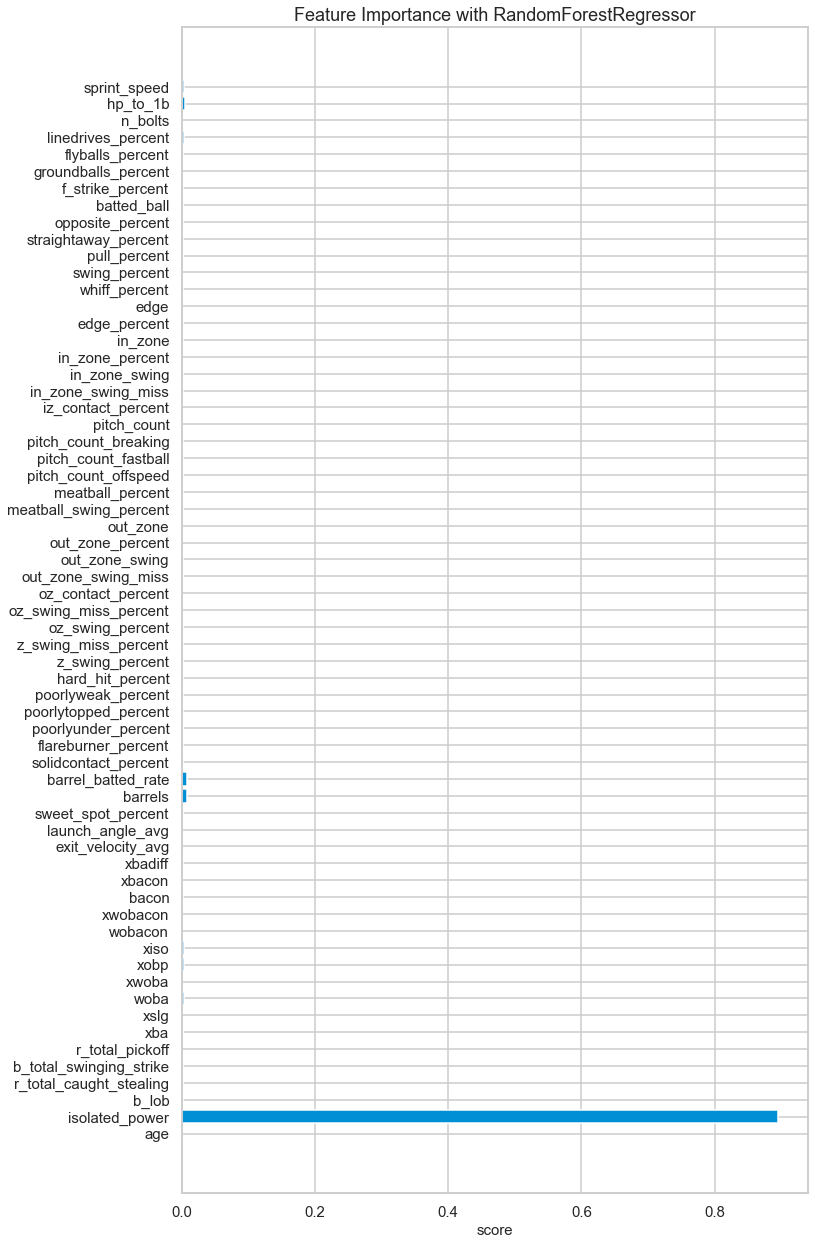

In [422]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_hr.columns, rf_important);
plt.title("Feature Importance with RandomForestRegressor")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [ ]:
pipe = Pipeline([
        ('RF', print("AVG RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegressor
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_hr, y_train_hr, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegressor
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_hr, y_train_hr, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

### XGBoost without PCA

In [423]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_hr, y_train_hr)
print("Randomized Search Finished")

Randomized Search Finished


In [424]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9527592270455922,
                              gamma=0.04960580086239186, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.04517044072038158,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=413, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.7760413714950751,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [425]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.9527592270455922, 
                               gamma = 0.04960580086239186, 
                               learning_rate = 0.04517044072038158, 
                               max_depth = 2, 
                               n_estimators = 413, 
                               subsample = 0.7760413714950751, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_hr,y_train_hr)

XG_hr_predictions = XGboost.predict(X_test_hr)

In [426]:
r2_score_xgboost = r2_score(y_test_hr, 
                             XG_hr_predictions)
r2_score_xgboost

0.9301711195439836

### XGBoost with PCA

In [427]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_hr, y_train_hr)
print("Randomized Search Finished")

Randomized Search Finished


In [428]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9202033627234993,
                              gamma=0.2262921051766607, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.07461097707989, max_delta_step=0,
                              max_depth=2, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=277,
                              n_jobs=0, num_parallel_tree=1, random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.43944904395211937,
                              tree_method='exact', validate_parameters=1,
                              verbosit

In [429]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.9202033627234993, 
                               gamma = 0.2262921051766607, 
                               learning_rate = 0.07461097707989, 
                               max_depth = 2, 
                               n_estimators = 277, 
                               subsample = 0.43944904395211937, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_hr,y_train_hr)

PCA_hr_predictions = XGboost_PCA.predict(X_test_hr)

In [430]:
r2_score_xgboost = r2_score(y_test_hr, 
                             PCA_hr_predictions)
r2_score_xgboost

0.9312697639506207

### Export your best model

In [431]:
PCA_hr_predictions = pd.DataFrame(PCA_hr_predictions)

In [432]:
PCA_hr_predictions = PCA_hr_predictions.join(names_df, how="inner")

In [433]:
PCA_hr_predictions = PCA_hr_predictions.pivot_table(index="name")
PCA_hr_predictions.head()

,0
name,
Abreu Jose,28.572300
Acuna Jr. Ronald,30.205410
Adames Willy,19.080589
Adams Matt,34.551128
Adrianza Ehire,13.448541


In [434]:
XG_hr_predictions = pd.DataFrame(XG_hr_predictions)

In [435]:
XG_hr_predictions = XG_hr_predictions.join(names_df, how="inner")

In [436]:
XG_hr_predictions = XG_hr_predictions.pivot_table(index="name")
XG_hr_predictions.head()

,0
name,
Abreu Jose,28.440561
Acuna Jr. Ronald,29.574171
Adames Willy,19.411898
Adams Matt,34.186840
Adrianza Ehire,13.188584


Lets use the PCA one, I like the results more and it seems to be overfitting less.

In [437]:
PCA_hr_predictions.to_csv("hr.csv")

In [104]:
XG_hr_predictions.to_csv("hr.csv")

# Runs Batted In

In [438]:
rbi_df = bat_df_norm[['name','year', 'age', 'isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','rbi']]
rbi_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,rbi
0,Anderson Brian,2020,27,0.210,81,0,1142.358079,0.0,0.228,0.425,...,23.0,353.711790,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,38
1,Encarnacion Edwin,2020,37,0.220,86,0,1200.000000,0.0,0.164,0.369,...,17.9,351.381215,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,19
2,Yastrzemski Mike,2020,30,0.271,63,1,981.333333,0.0,0.255,0.496,...,20.4,365.333333,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,35
3,Marte Ketel,2020,27,0.122,54,0,963.076923,0.0,0.265,0.379,...,23.3,501.538462,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,17
4,Soler Jorge,2020,28,0.215,46,0,972.413793,0.0,0.244,0.490,...,22.2,310.344828,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,24


Lets see the distributions first

In [84]:
# Average rating of apps
avg_rbi = rbi_df["rbi"].mean(skipna=True)
print('Average app rating = ', avg_rbi)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = rbi_df['rbi']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_rbi,
              'y0': 0,
              'x1': avg_rbi,
              'y1': 30,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  18.536130191792065


## Train-Test (X,y) Splitting

In [439]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_rbi = rbi_df.loc[rbi_df["year"]<2019,:].drop(columns=["rbi", "year","name"])
y_train_rbi = rbi_df.loc[rbi_df["year"]<2019,"rbi"] #target column

X_test_rbi = rbi_df.loc[rbi_df["year"]==2019,:].drop(columns=["rbi", "year","name"])
y_test_rbi = rbi_df.loc[rbi_df["year"]==2019,"rbi"] #target column

In [440]:
y_test_rbi.head()

745    93
746    59
747    12
748    61
749    57
Name: rbi, dtype: int64

## Feature Importance

In [441]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_rbi, y_train_rbi)

RandomForestRegressor()

In [442]:
#sort the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_rbi.columns,)
rf_important.sort_values(ascending=False)

b_lob                      0.762685
woba                       0.072053
isolated_power             0.047216
xslg                       0.043967
xiso                       0.003870
                             ...   
oz_contact_percent         0.000683
r_total_caught_stealing    0.000631
swing_percent              0.000620
z_swing_miss_percent       0.000545
iz_contact_percent         0.000473
Length: 63, dtype: float64

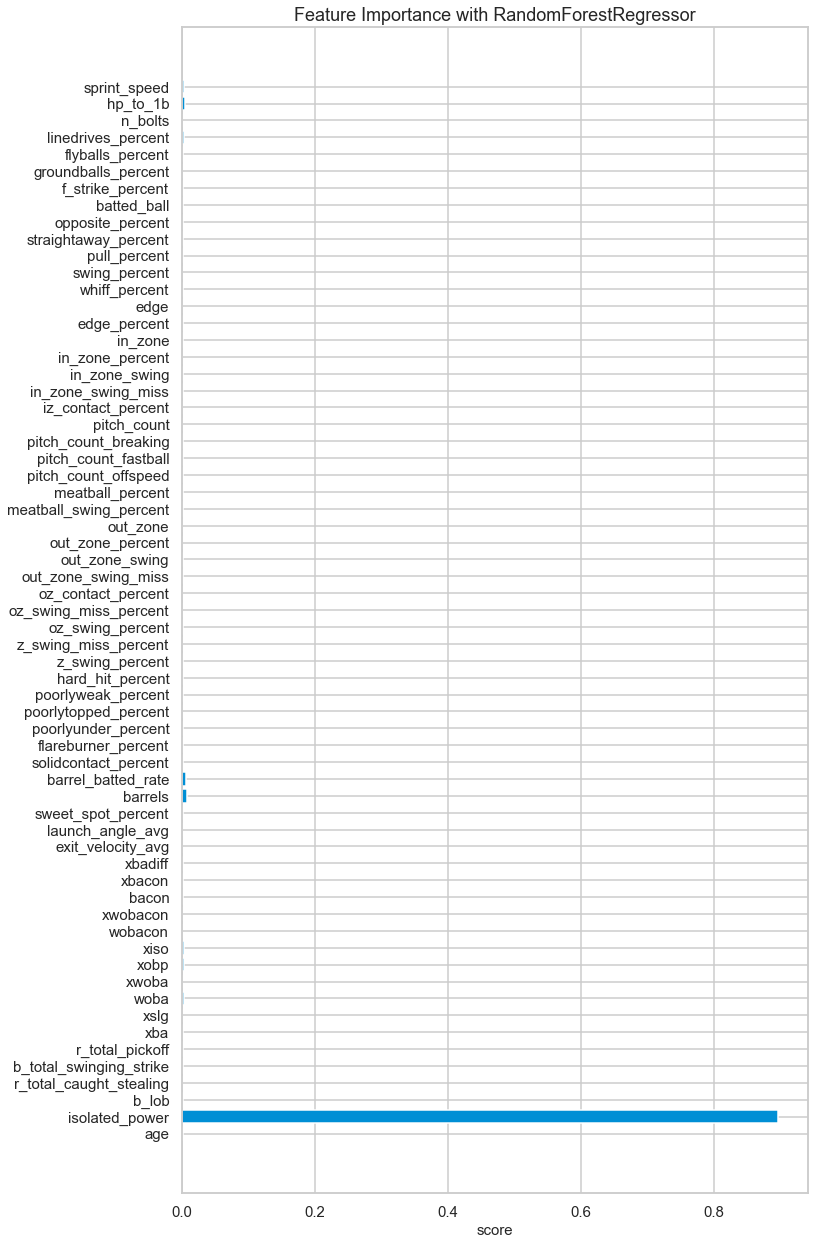

In [89]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_rbi.columns, rf_important);
plt.title("Feature Importance with RandomForestRegressor")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [ ]:
pipe = Pipeline([
        ('RF', print("AVG RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegressor
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_rbi, y_train_rbi, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegressor
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_rbi, y_train_rbi, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

### XGBoost without PCA

In [443]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_rbi, y_train_rbi)
print("Randomized Search Finished")

Randomized Search Finished


In [444]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7685089534358902,
                              gamma=0.47259094595868784, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.07332673517263702,
                              max_delta_step=0, max_depth=4, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=216, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.8859858173007756,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [445]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.7685089534358902, 
                               gamma = 0.47259094595868784, 
                               learning_rate = 0.07332673517263702, 
                               max_depth = 4, 
                               n_estimators = 216, 
                               subsample = 0.8859858173007756, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_rbi,y_train_rbi)

XG_rbi_predictions = XGboost.predict(X_test_rbi)

In [446]:
r2_score_xgboost = r2_score(y_test_rbi, 
                             XG_rbi_predictions)
r2_score_xgboost

0.9203008752698835

### XGBoost with PCA

In [447]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_rbi, y_train_rbi)
print("Randomized Search Finished")

Randomized Search Finished


In [448]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8106421471675721,
                              gamma=0.2501564531414249, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.11500185538113343,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=433, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.51692823992826,
                              tree_method='exact', validate_parameters=1,
                              verbosit

In [449]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.8106421471675721, 
                               gamma = 0.2501564531414249, 
                               learning_rate = 0.11500185538113343, 
                               max_depth = 2, 
                               n_estimators = 433, 
                               subsample = 0.51692823992826, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_rbi,y_train_rbi)

PCA_rbi_predictions = XGboost_PCA.predict(X_test_rbi)

In [450]:
r2_score_xgboost = r2_score(y_test_rbi, 
                             PCA_rbi_predictions)
r2_score_xgboost

0.9183129872179939

### Export your best model

In [451]:
PCA_rbi_predictions = pd.DataFrame(PCA_rbi_predictions)

In [452]:
PCA_rbi_predictions = PCA_rbi_predictions.join(names_df, how="inner")

In [453]:
PCA_rbi_predictions = PCA_rbi_predictions.pivot_table(index="name")
PCA_rbi_predictions.head()

,0
name,
Abreu Jose,95.831024
Acuna Jr. Ronald,79.048920
Adames Willy,68.051323
Adams Matt,49.547741
Adrianza Ehire,24.994642


In [454]:
XG_rbi_predictions = pd.DataFrame(XG_rbi_predictions)

In [455]:
XG_rbi_predictions = XG_rbi_predictions.join(names_df, how="inner")

In [456]:
XG_rbi_predictions = XG_rbi_predictions.pivot_table(index="name")
XG_rbi_predictions.head()

,0
name,
Abreu Jose,98.110939
Acuna Jr. Ronald,77.332512
Adames Willy,68.258224
Adams Matt,53.275658
Adrianza Ehire,22.241917


Lets use the PCA one, I like the results more and it seems to be overfitting less.

In [457]:
PCA_rbi_predictions.to_csv("rbi.csv")

In [104]:
XG_rbi_predictions.to_csv("rbi.csv")

# Runs

In [458]:
runs_df = bat_df_norm[['name','year', 'age', 'isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','runs']]
runs_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,runs
0,Anderson Brian,2020,27,0.210,81,0,1142.358079,0.0,0.228,0.425,...,23.0,353.711790,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,70.742358
1,Encarnacion Edwin,2020,37,0.220,86,0,1200.000000,0.0,0.164,0.369,...,17.9,351.381215,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,62.983425
2,Yastrzemski Mike,2020,30,0.271,63,1,981.333333,0.0,0.255,0.496,...,20.4,365.333333,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,104.000000
3,Marte Ketel,2020,27,0.122,54,0,963.076923,0.0,0.265,0.379,...,23.3,501.538462,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,58.461538
4,Soler Jorge,2020,28,0.215,46,0,972.413793,0.0,0.244,0.490,...,22.2,310.344828,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,58.620690


Lets see the distributions first

In [459]:
# Average rating of apps
avg_runs = runs_df["runs"].mean(skipna=True)
print('Average app rating = ', avg_runs)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = runs_df['runs']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_runs,
              'y0': 0,
              'x1': avg_runs,
              'y1': 30,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  71.16613200686236


## Train-Test (X,y) Splitting

In [460]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_runs = runs_df.loc[runs_df["year"]<2019,:].drop(columns=["runs", "year","name"])
y_train_runs = runs_df.loc[runs_df["year"]<2019,"runs"] #target column

X_test_runs = runs_df.loc[runs_df["year"]==2019,:].drop(columns=["runs", "year","name"])
y_test_runs = runs_df.loc[runs_df["year"]==2019,"runs"] #target column

In [461]:
y_test_runs.head()

745    60.550459
746    44.808743
747    41.803279
748    84.545455
749    59.734513
Name: runs, dtype: float64

## Feature Importance

In [462]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_runs, y_train_runs)

RandomForestRegressor()

In [463]:
#sort the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_runs.columns,)
rf_important.sort_values(ascending=False)

woba                     0.438251
sprint_speed             0.064889
hp_to_1b                 0.050423
isolated_power           0.027075
n_bolts                  0.022393
                           ...   
whiff_percent            0.004040
barrels                  0.003978
oz_swing_miss_percent    0.003703
z_swing_miss_percent     0.003023
barrel_batted_rate       0.003019
Length: 63, dtype: float64

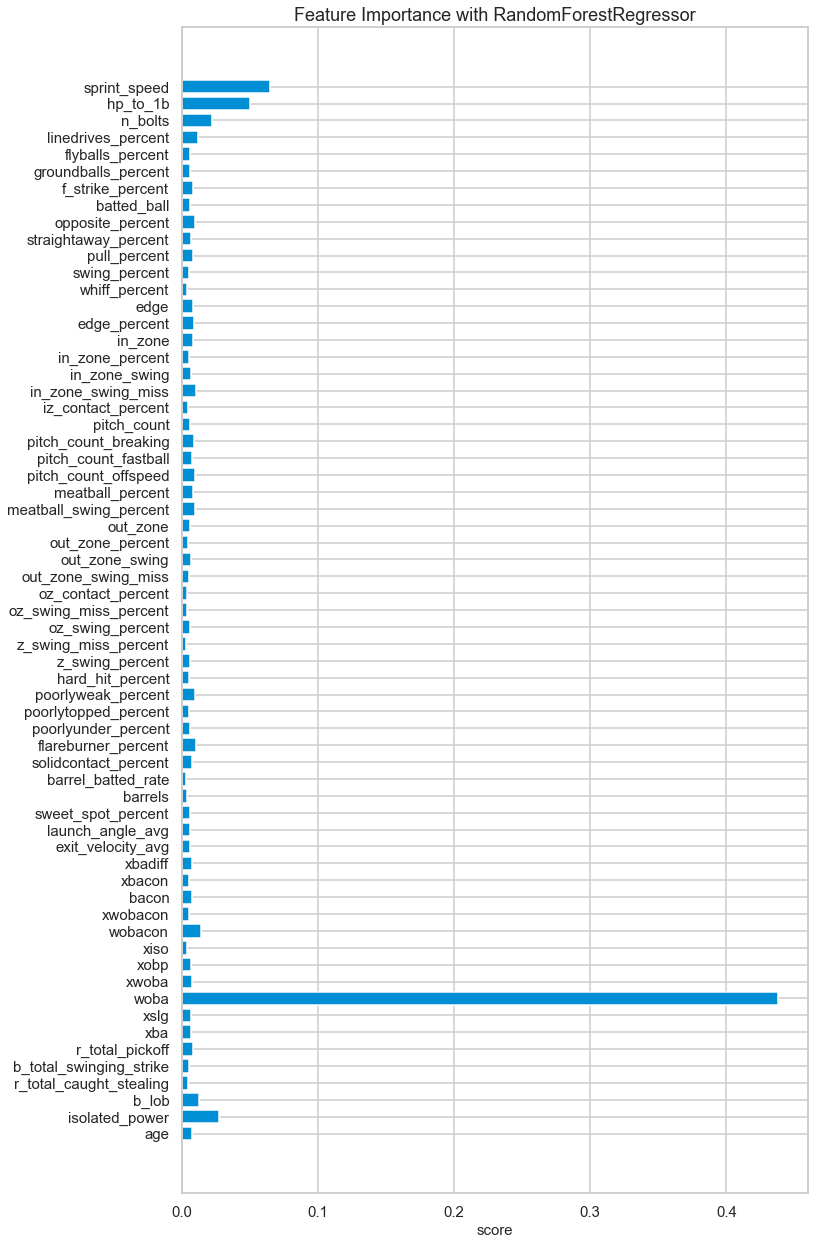

In [464]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_runs.columns, rf_important);
plt.title("Feature Importance with RandomForestRegressor")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [ ]:
pipe = Pipeline([
        ('RF', print("AVG RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegressor
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_runs, y_train_runs, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegressor
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_runs, y_train_runs, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

### XGBoost without PCA

In [465]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_runs, y_train_runs)
print("Randomized Search Finished")

Randomized Search Finished


In [466]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7217335148128637,
                              gamma=0.10449399165889417, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.05897717881716666,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=247, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.5981350222793772,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [467]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.7217335148128637, 
                               gamma = 0.10449399165889417, 
                               learning_rate = 0.05897717881716666, 
                               max_depth = 2, 
                               n_estimators = 247, 
                               subsample = 0.5981350222793772, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_runs,y_train_runs)

XG_runs_predictions = XGboost.predict(X_test_runs)

In [468]:
r2_score_xgboost = r2_score(y_test_runs, 
                             XG_runs_predictions)
r2_score_xgboost

0.6027369559899374

### XGBoost with PCA

In [469]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_runs, y_train_runs)
print("Randomized Search Finished")

Randomized Search Finished


In [470]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8226686354702246,
                              gamma=0.18411734887192915, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.04721461163520395,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=397, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.43755371387223796,
                              tree_method='exact', validate_parameters=1,
                              verb

In [471]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.8226686354702246, 
                               gamma = 0.18411734887192915, 
                               learning_rate = 0.04721461163520395, 
                               max_depth = 3, 
                               n_estimators = 397, 
                               subsample = 0.43755371387223796, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_runs,y_train_runs)

PCA_runs_predictions = XGboost_PCA.predict(X_test_runs)

In [472]:
r2_score_xgboost = r2_score(y_test_runs, 
                             PCA_runs_predictions)
r2_score_xgboost

0.5963378265624832

### Export your best model

In [473]:
PCA_runs_predictions = pd.DataFrame(PCA_runs_predictions)

In [474]:
PCA_runs_predictions = PCA_runs_predictions.join(names_df, how="inner")

In [475]:
PCA_runs_predictions = PCA_runs_predictions.pivot_table(index="name")
PCA_runs_predictions.head()

,0
name,
Abreu Jose,73.455521
Acuna Jr. Ronald,95.827354
Adames Willy,70.694626
Adams Matt,62.912758
Adrianza Ehire,70.468140


In [476]:
XG_runs_predictions = pd.DataFrame(XG_runs_predictions)

In [477]:
XG_runs_predictions = XG_runs_predictions.join(names_df, how="inner")

In [478]:
XG_runs_predictions = XG_runs_predictions.pivot_table(index="name")
XG_runs_predictions.head()

,0
name,
Abreu Jose,73.952805
Acuna Jr. Ronald,95.095894
Adames Willy,70.873627
Adams Matt,64.423538
Adrianza Ehire,69.184952


Lets use the PCA one, I like the results more and it seems to be overfitting less.

In [53]:
PCA_runs_predictions.to_csv("runs.csv")

In [479]:
XG_runs_predictions.to_csv("runs.csv")

# Strike Outs

In [39]:
so_df = bat_df_norm[['name','year', 'age', 'isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','so']]
so_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,so
0,Anderson Brian,2020,27,0.210,81,0,1142.358079,0.0,0.228,0.425,...,23.0,353.711790,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,172.925764
1,Encarnacion Edwin,2020,37,0.220,86,0,1200.000000,0.0,0.164,0.369,...,17.9,351.381215,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,179.005525
2,Yastrzemski Mike,2020,30,0.271,63,1,981.333333,0.0,0.255,0.496,...,20.4,365.333333,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,146.666667
3,Marte Ketel,2020,27,0.122,54,0,963.076923,0.0,0.265,0.379,...,23.3,501.538462,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,64.615385
4,Soler Jorge,2020,28,0.215,46,0,972.413793,0.0,0.244,0.490,...,22.2,310.344828,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,206.896552


Lets see the distributions first

In [45]:
# Average rating of apps
avg_so = so_df["so"].mean(skipna=True)
print('Average app rating = ', avg_so)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = so_df['so']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_so,
              'y0': 0,
              'x1': avg_so,
              'y1': 30,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  131.4589246937803


## Train-Test (X,y) Splitting

In [46]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_so = so_df.loc[so_df["year"]<2019,:].drop(columns=["so", "year","name"])
y_train_so = so_df.loc[so_df["year"]<2019,"so"] #target column

X_test_so = so_df.loc[so_df["year"]==2019,:].drop(columns=["so", "year","name"])
y_test_so = so_df.loc[so_df["year"]==2019,"so"] #target column

In [47]:
y_test_so.head()

745     74.862385
746    118.032787
747    213.934426
748    150.000000
749     76.991150
Name: so, dtype: float64

## Feature Importance

In [48]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_so, y_train_so)

RandomForestRegressor()

In [49]:
#sort the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_so.columns,)
rf_important.sort_values(ascending=False)

batted_ball                0.474674
whiff_percent              0.409043
xobp                       0.057829
xbacon                     0.005183
out_zone_swing_miss        0.003813
                             ...   
barrel_batted_rate         0.000355
barrels                    0.000324
r_total_caught_stealing    0.000314
n_bolts                    0.000288
xslg                       0.000278
Length: 63, dtype: float64

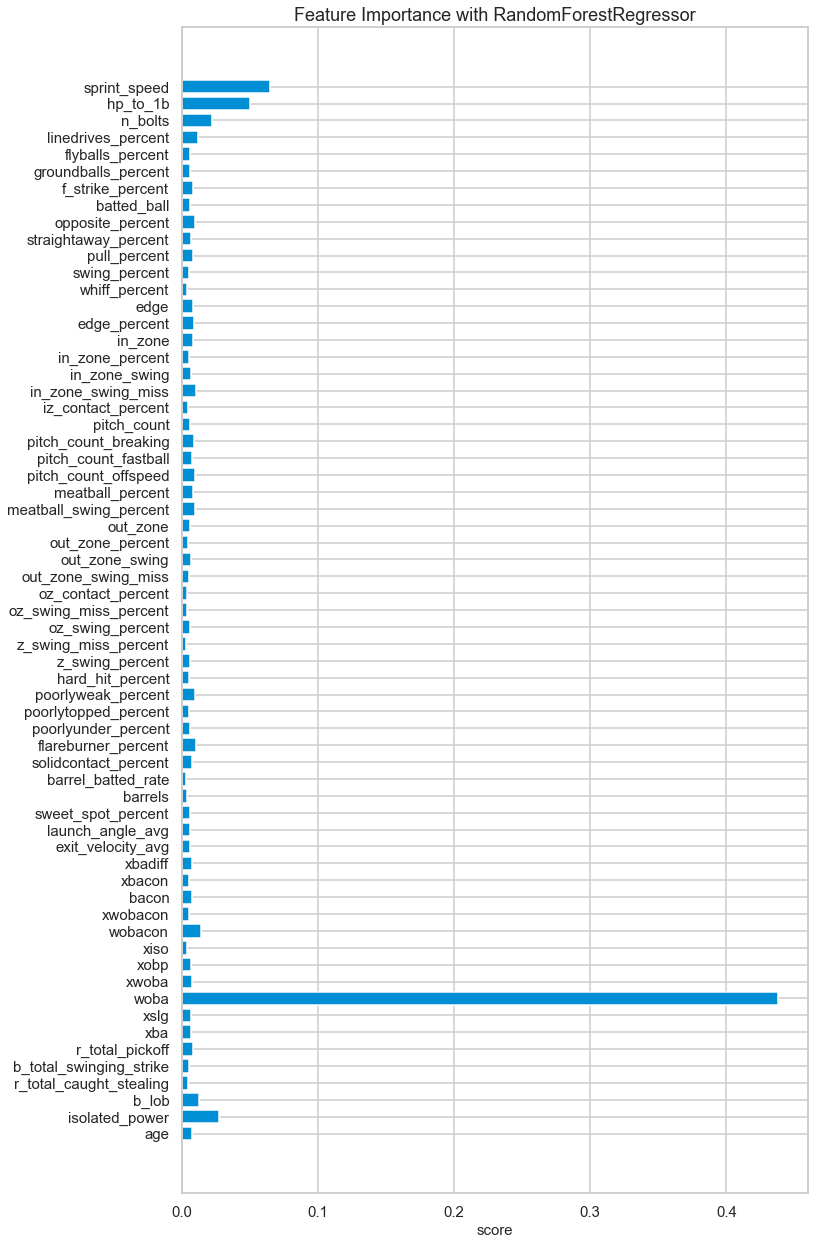

In [464]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_so.columns, rf_important);
plt.title("Feature Importance with RandomForestRegressor")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [ ]:
pipe = Pipeline([
        ('RF', print("AVG RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegressor
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_so, y_train_so, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegressor
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_so, y_train_so, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

### XGBoost without PCA

In [52]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_so, y_train_so)
print("Randomized Search Finished")

Randomized Search Finished


In [53]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7848547432672395,
                              gamma=0.062492860387053595, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.1598405270442202,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=362, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.5528110012071747,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [58]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.7848547432672395, 
                               gamma = 0.062492860387053595, 
                               learning_rate = 0.1598405270442202, 
                               max_depth = 2, 
                               n_estimators = 362, 
                               subsample = 0.5528110012071747, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_so,y_train_so)

XG_so_predictions = XGboost.predict(X_test_so)

In [59]:
r2_score_xgboost = r2_score(y_test_so, 
                             XG_so_predictions)
r2_score_xgboost

0.9897895849222406

### XGBoost with PCA

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_so, y_train_so)
print("Randomized Search Finished")

C:\Users\alain\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Randomized Search Finished


In [55]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7366120821055036,
                              gamma=0.3738094997519976, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.1299415810788579,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=393, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.3714737824359994,
                              tree_method='exact', validate_parameters=1,
                              verbosi

In [56]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.7366120821055036, 
                               gamma = 0.3738094997519976, 
                               learning_rate = 0.1299415810788579, 
                               max_depth = 2, 
                               n_estimators = 393, 
                               subsample = 0.3714737824359994, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_so,y_train_so)

PCA_so_predictions = XGboost_PCA.predict(X_test_so)

In [57]:
r2_score_xgboost = r2_score(y_test_so, 
                             PCA_so_predictions)
r2_score_xgboost

0.9881470847890481

### Export your best model

In [72]:
PCA_so_predictions = pd.DataFrame(PCA_so_predictions)

In [73]:
PCA_so_predictions = PCA_so_predictions.join(names_df, how="inner")

In [74]:
PCA_so_predictions = PCA_so_predictions.pivot_table(index="name")
PCA_so_predictions.head()

,0
name,
Abreu Jose,127.491478
Acuna Jr. Ronald,153.745880
Adames Willy,155.720078
Adams Matt,203.998703
Adrianza Ehire,99.676422


In [75]:
XG_so_predictions = pd.DataFrame(XG_so_predictions)

In [76]:
XG_so_predictions = XG_so_predictions.join(names_df, how="inner")

In [77]:
XG_so_predictions = XG_so_predictions.pivot_table(index="name")
XG_so_predictions.head()

,0
name,
Abreu Jose,128.373337
Acuna Jr. Ronald,158.057266
Adames Willy,154.759628
Adams Matt,209.816071
Adrianza Ehire,102.285248


Lets use the PCA one, I like the results more and it seems to be overfitting less.

In [53]:
PCA_so_predictions.to_csv("so.csv")

In [78]:
XG_so_predictions.to_csv("so.csv")

# Walks

In [45]:
bb_df = bat_df_norm[['name','year', 'age', 'isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','bb']]
bb_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,bb
0,Anderson Brian,2020,27,0.210,81,0,1142.358079,0.0,0.228,0.425,...,23.0,353.711790,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,57.641921
1,Encarnacion Edwin,2020,37,0.220,86,0,1200.000000,0.0,0.164,0.369,...,17.9,351.381215,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,53.038674
2,Yastrzemski Mike,2020,30,0.271,63,1,981.333333,0.0,0.255,0.496,...,20.4,365.333333,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,80.000000
3,Marte Ketel,2020,27,0.122,54,0,963.076923,0.0,0.265,0.379,...,23.3,501.538462,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,21.538462
4,Soler Jorge,2020,28,0.215,46,0,972.413793,0.0,0.244,0.490,...,22.2,310.344828,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,65.517241


Lets see the distributions first

In [85]:
# Average rating of apps
avg_bb = bb_df["bb"].mean(skipna=True)
print('Average app rating = ', avg_bb)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = bb_df['bb']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_bb,
              'y0': 0,
              'x1': avg_bb,
              'y1': 30,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  50.34236633075689


## Train-Test (X,y) Splitting

In [46]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_bb = bb_df.loc[bb_df["year"]<2019,:].drop(columns=["bb", "year","name"])
y_train_bb = bb_df.loc[bb_df["year"]<2019,"bb"] #target column

X_test_bb = bb_df.loc[bb_df["year"]==2019,:].drop(columns=["bb", "year","name"])
y_test_bb = bb_df.loc[bb_df["year"]==2019,"bb"] #target column

In [47]:
y_test_bb.head()

745    47.339450
746    52.459016
747    36.885246
748    70.909091
749    30.530973
Name: bb, dtype: float64

## Feature Importance

In [92]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regresbbr
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_bb, y_train_bb)

RandomForestRegressor()

In [93]:
#bbrt the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_bb.columns,)
rf_important.sort_values(ascending=False)

oz_swing_percent           0.412907
xobp                       0.210576
out_zone                   0.115011
batted_ball                0.062606
xba                        0.035296
                             ...   
oz_swing_miss_percent      0.001265
barrels                    0.001196
oz_contact_percent         0.001173
n_bolts                    0.001155
r_total_caught_stealing    0.001089
Length: 63, dtype: float64

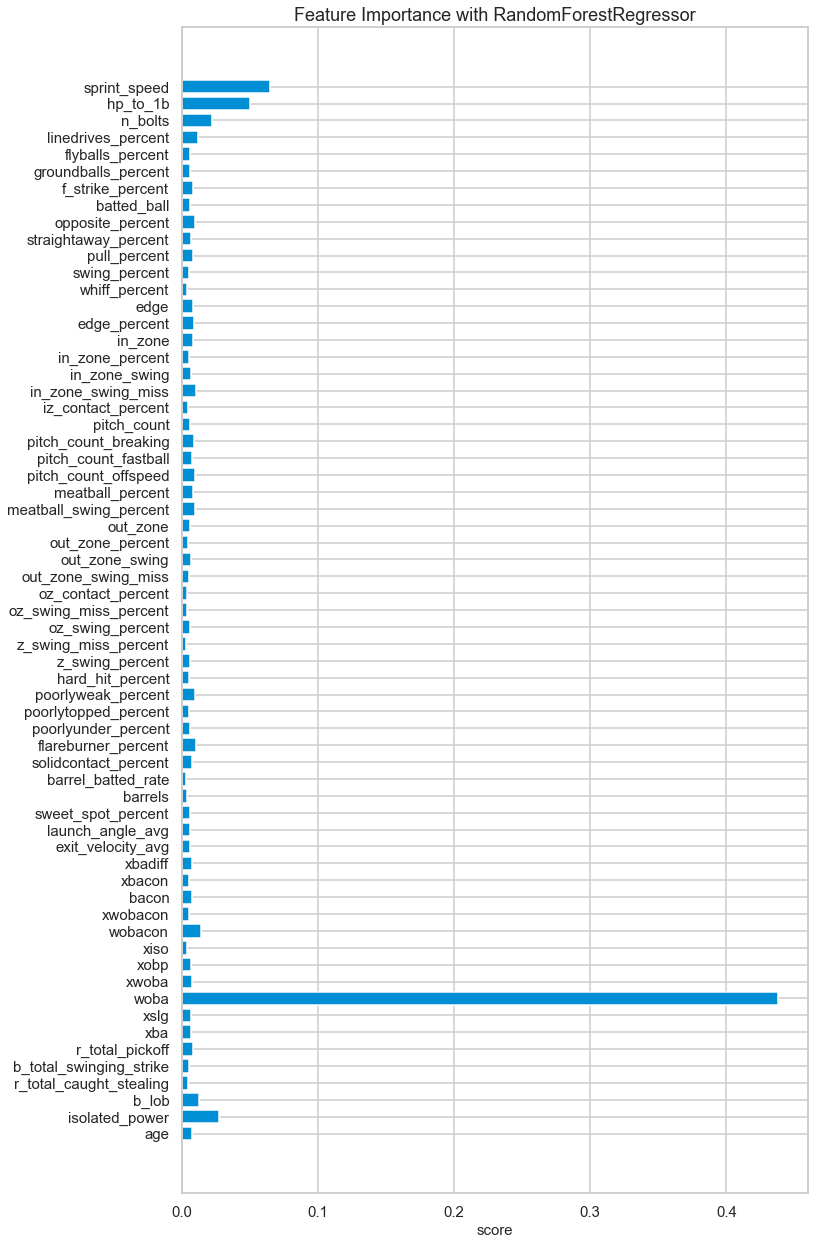

In [464]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_bb.columns, rf_important);
plt.title("Feature Importance with RandomForestRegresbbr")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [ ]:
pipe = Pipeline([
        ('RF', print("AVG RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegresbbr
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_bb, y_train_bb, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegresbbr
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_bb, y_train_bb, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

### XGBoost without PCA

In [94]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_bb, y_train_bb)
print("Randomized Search Finished")

Randomized Search Finished


In [95]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8577644909920503,
                              gamma=0.2100413332607992, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.041297618729077376,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=441, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.46053750824470474,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [58]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.8577644909920503, 
                               gamma = 0.2100413332607992, 
                               learning_rate = 0.041297618729077376, 
                               max_depth = 2, 
                               n_estimators = 441, 
                               subsample = 0.46053750824470474, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_bb,y_train_bb)

XG_bb_predictions = XGboost.predict(X_test_bb)

In [59]:
r2_score_xgboost = r2_score(y_test_bb, 
                             XG_bb_predictions)
r2_score_xgboost

0.8993487279563133

### XGBoost with PCA

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_bb, y_train_bb)
print("Randomized Search Finished")

Randomized Search Finished


In [49]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8208848344011664,
                              gamma=0.37761261126619483, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.07043108712835618,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=429, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.5468287445271248,
                              tree_method='exact', validate_parameters=1,
                              verbo

In [50]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.8208848344011664, 
                               gamma = 0.37761261126619483, 
                               learning_rate = 0.07043108712835618, 
                               max_depth = 2, 
                               n_estimators = 429, 
                               subsample = 0.5468287445271248, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_bb,y_train_bb)

PCA_bb_predictions = XGboost_PCA.predict(X_test_bb)

In [51]:
r2_score_xgboost = r2_score(y_test_bb, 
                             PCA_bb_predictions)
r2_score_xgboost

0.9044484344059114

### Export your best model

In [52]:
PCA_bb_predictions = pd.DataFrame(PCA_bb_predictions)

In [53]:
PCA_bb_predictions = PCA_bb_predictions.join(names_df, how="inner")

In [54]:
PCA_bb_predictions = PCA_bb_predictions.pivot_table(index="name")
PCA_bb_predictions.head()

,0
name,
Abreu Jose,38.301044
Acuna Jr. Ronald,70.738388
Adames Willy,48.993214
Adams Matt,36.877644
Adrianza Ehire,54.904213


In [60]:
XG_bb_predictions = pd.DataFrame(XG_bb_predictions)

In [61]:
XG_bb_predictions = XG_bb_predictions.join(names_df, how="inner")

In [62]:
XG_bb_predictions = XG_bb_predictions.pivot_table(index="name")
XG_bb_predictions.head()

,0
name,
Abreu Jose,39.745144
Acuna Jr. Ronald,70.978836
Adames Willy,47.799862
Adams Matt,37.828522
Adrianza Ehire,53.286491


Lets use the PCA one, I like the results more and it seems to be overfitting less.

In [63]:
PCA_bb_predictions.to_csv("bb.csv")

In [104]:
XG_bb_predictions.to_csv("bb.csv")

# Extra Base Hits

In [65]:
xbh_df = bat_df_norm[['name','year', 'age', 'isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','xbh']]
xbh_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,xbh
0,Anderson Brian,2020,27,0.210,81,0,1142.358079,0.0,0.228,0.425,...,23.0,353.711790,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,50.54
1,Encarnacion Edwin,2020,37,0.220,86,0,1200.000000,0.0,0.164,0.369,...,17.9,351.381215,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,39.90
2,Yastrzemski Mike,2020,30,0.271,63,1,981.333333,0.0,0.255,0.496,...,20.4,365.333333,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,74.48
3,Marte Ketel,2020,27,0.122,54,0,963.076923,0.0,0.265,0.379,...,23.3,501.538462,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,45.22
4,Soler Jorge,2020,28,0.215,46,0,972.413793,0.0,0.244,0.490,...,22.2,310.344828,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,42.56


Lets see the distributions first

In [66]:
# Average rating of apps
avg_xbh = xbh_df["xbh"].mean(skipna=True)
print('Average app rating = ', avg_xbh)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = xbh_df['xbh']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_xbh,
              'y0': 0,
              'x1': avg_xbh,
              'y1': 30,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  33.431096161456274


## Train-Test (X,y) Splitting

In [67]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_xbh = xbh_df.loc[xbh_df["year"]<2019,:].drop(columns=["xbh", "year","name"])
y_train_xbh = xbh_df.loc[xbh_df["year"]<2019,"xbh"] #target column

X_test_xbh = xbh_df.loc[xbh_df["year"]==2019,:].drop(columns=["xbh", "year","name"])
y_test_xbh = xbh_df.loc[xbh_df["year"]==2019,"xbh"] #target column

In [68]:
y_test_xbh.head()

745    45.0
746    33.0
747    11.0
748    57.0
749    34.0
Name: xbh, dtype: float64

## Feature Importance

In [69]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regresxbhr
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_xbh, y_train_xbh)

RandomForestRegressor()

In [70]:
#xbhrt the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_xbh.columns,)
rf_important.sort_values(ascending=False)

b_lob                      0.714036
woba                       0.128993
isolated_power             0.082670
wobacon                    0.004164
r_total_caught_stealing    0.002641
                             ...   
n_bolts                    0.000702
in_zone_percent            0.000698
out_zone_percent           0.000638
oz_contact_percent         0.000635
xwobacon                   0.000539
Length: 63, dtype: float64

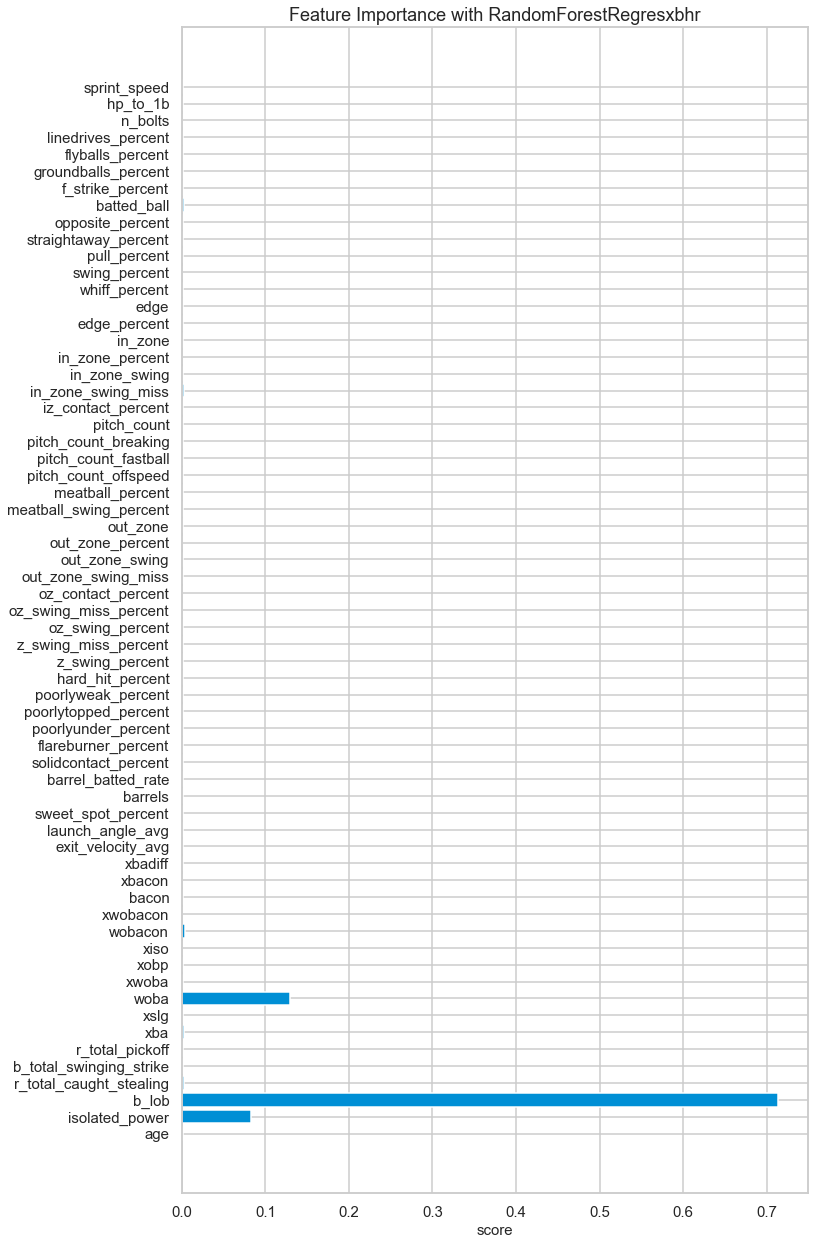

In [71]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_xbh.columns, rf_important);
plt.title("Feature Importance with RandomForestRegresxbhr")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [ ]:
pipe = Pipeline([
        ('RF', print("AVG RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegresxbhr
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_xbh, y_train_xbh, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegresxbhr
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_xbh, y_train_xbh, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

### XGBoost without PCA

In [72]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_xbh, y_train_xbh)
print("Randomized Search Finished")

Randomized Search Finished


In [73]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9378972462601187,
                              gamma=0.3755567691561008, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.07813205241601164,
                              max_delta_step=0, max_depth=4, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=348, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.7931579812802834,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [75]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.9378972462601187, 
                               gamma = 0.3755567691561008, 
                               learning_rate = 0.07813205241601164, 
                               max_depth = 4, 
                               n_estimators = 348, 
                               subsample = 0.7931579812802834, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_xbh,y_train_xbh)

XG_xbh_predictions = XGboost.predict(X_test_xbh)

In [76]:
r2_score_xgboost = r2_score(y_test_xbh, 
                             XG_xbh_predictions)
r2_score_xgboost

0.9479231485702719

### XGBoost with PCA

In [77]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_xbh, y_train_xbh)
print("Randomized Search Finished")

Randomized Search Finished


In [78]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7373541125413166,
                              gamma=0.4561499565255934, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.08282675417596017,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=254, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.4137600886029701,
                              tree_method='exact', validate_parameters=1,
                              verbos

In [81]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.7373541125413166, 
                               gamma = 0.4561499565255934, 
                               learning_rate = 0.08282675417596017, 
                               max_depth = 3, 
                               n_estimators = 254, 
                               subsample = 0.4137600886029701, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_xbh,y_train_xbh)

PCA_xbh_predictions = XGboost_PCA.predict(X_test_xbh)

In [82]:
r2_score_xgboost = r2_score(y_test_xbh, 
                             PCA_xbh_predictions)
r2_score_xgboost

0.9495784573408321

### Export your best model

In [83]:
PCA_xbh_predictions = pd.DataFrame(PCA_xbh_predictions)

In [84]:
PCA_xbh_predictions = PCA_xbh_predictions.join(names_df, how="inner")

In [85]:
PCA_xbh_predictions = PCA_xbh_predictions.pivot_table(index="name")
PCA_xbh_predictions.head()

,0
name,
Abreu Jose,64.534698
Acuna Jr. Ronald,69.936699
Adames Willy,45.088951
Adams Matt,32.462372
Adrianza Ehire,19.896709


In [86]:
XG_xbh_predictions = pd.DataFrame(XG_xbh_predictions)

In [87]:
XG_xbh_predictions = XG_xbh_predictions.join(names_df, how="inner")

In [88]:
XG_xbh_predictions = XG_xbh_predictions.pivot_table(index="name")
XG_xbh_predictions.head()

,0
name,
Abreu Jose,64.591942
Acuna Jr. Ronald,70.104889
Adames Willy,50.078861
Adams Matt,33.805351
Adrianza Ehire,17.680086


Lets use the PCA one, I like the results more and it seems to be overfitting less.

In [89]:
PCA_xbh_predictions.to_csv("xbh.csv")

In [104]:
XG_xbh_predictions.to_csv("xbh.csv")

# Average

In [43]:
avg_df = bat_df_norm[['name','year', 'age', 'isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','avg']]
avg_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,avg
0,Anderson Brian,2020,27,0.210,81,0,1142.358079,0.0,0.228,0.425,...,23.0,353.711790,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,0.255
1,Encarnacion Edwin,2020,37,0.220,86,0,1200.000000,0.0,0.164,0.369,...,17.9,351.381215,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,0.157
2,Yastrzemski Mike,2020,30,0.271,63,1,981.333333,0.0,0.255,0.496,...,20.4,365.333333,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,0.297
3,Marte Ketel,2020,27,0.122,54,0,963.076923,0.0,0.265,0.379,...,23.3,501.538462,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,0.287
4,Soler Jorge,2020,28,0.215,46,0,972.413793,0.0,0.244,0.490,...,22.2,310.344828,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,0.228


Lets see the distributions first

In [44]:
# Average rating of apps
avg_avg = avg_df["avg"].mean(skipna=True)
print('Average app rating = ', avg_avg)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = avg_df['avg']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_avg,
              'y0': 0,
              'x1': avg_avg,
              'y1': 30,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  0.2508935496636327


## Train-Test (X,y) Splitting

In [45]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_avg = avg_df.loc[avg_df["year"]<2019,:].drop(columns=["avg", "year","name"])
y_train_avg = avg_df.loc[avg_df["year"]<2019,"avg"] #target column

X_test_avg = avg_df.loc[avg_df["year"]==2019,:].drop(columns=["avg", "year","name"])
y_test_avg = avg_df.loc[avg_df["year"]==2019,"avg"] #target column

In [46]:
y_test_avg.head()

745    0.244
746    0.282
747    0.158
748    0.265
749    0.270
Name: avg, dtype: float64

## Feature Importance

In [47]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regresavgr
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_avg, y_train_avg)

RandomForestRegressor()

In [48]:
#avgrt the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_avg.columns,)
rf_important.sort_values(ascending=False)

xba                        0.562002
xbadiff                    0.221309
bacon                      0.144698
woba                       0.031413
batted_ball                0.018302
                             ...   
barrel_batted_rate         0.000154
r_total_caught_stealing    0.000147
barrels                    0.000138
xslg                       0.000126
xiso                       0.000112
Length: 63, dtype: float64

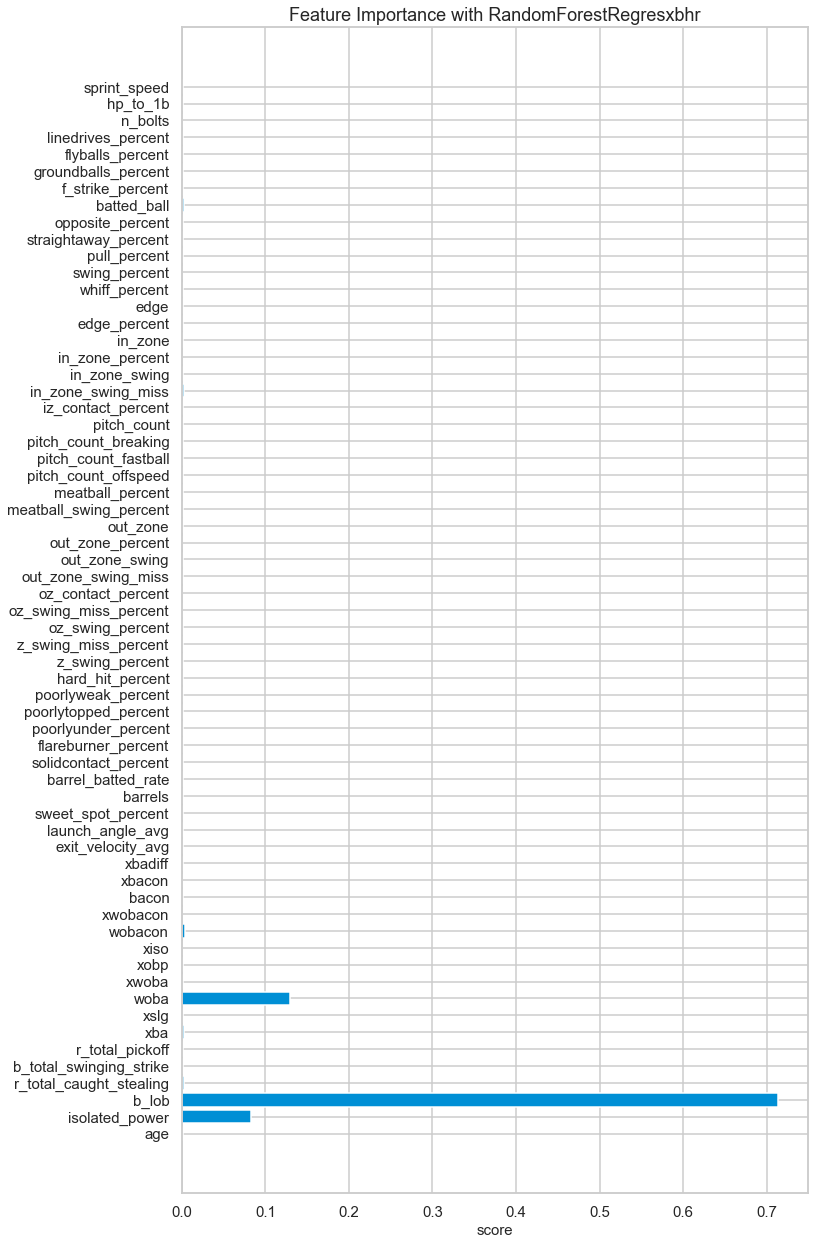

In [71]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_avg.columns, rf_important);
plt.title("Feature Importance with RandomForestRegresavgr")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [ ]:
pipe = Pipeline([
        ('RF', print("AVG RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegresavgr
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_avg, y_train_avg, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegresavgr
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_avg, y_train_avg, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

### XGBoost without PCA

In [96]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_avg, y_train_avg)
print("Randomized Search Finished")

Randomized Search Finished


In [97]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7276261471359665,
                              gamma=0.0022909897921846722, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.1553530040427105,
                              max_delta_step=0, max_depth=11,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=347,
                              n_jobs=0, num_parallel_tree=1, random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.4854386232993928, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [49]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.7276261471359665, 
                               gamma = 0.0022909897921846722, 
                               learning_rate = 0.1553530040427105, 
                               max_depth = 11, 
                               n_estimators = 347, 
                               subsample = 0.4854386232993928, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_avg,y_train_avg)

XG_avg_predictions = XGboost.predict(X_test_avg)

In [50]:
r2_score_xgboost = r2_score(y_test_avg, 
                             XG_avg_predictions)
r2_score_xgboost

0.967334296455906

### XGBoost with PCA

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_avg, y_train_avg)
print("Randomized Search Finished")

Randomized Search Finished


In [52]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9115035125440744,
                              gamma=0.005853853792132269, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.1559819890729838,
                              max_delta_step=0, max_depth=18,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=318,
                              n_jobs=0, num_parallel_tree=1, random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.6744884282655466, tree_method='exact',
                              validate_parameters=1, verb

In [53]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.9115035125440744, 
                               gamma = 0.005853853792132269, 
                               learning_rate = 0.1559819890729838, 
                               max_depth = 18, 
                               n_estimators = 318, 
                               subsample = 0.6744884282655466, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_avg,y_train_avg)

PCA_avg_predictions = XGboost_PCA.predict(X_test_avg)

In [54]:
r2_score_xgboost = r2_score(y_test_avg, 
                             PCA_avg_predictions)
r2_score_xgboost

0.9536545750550244

### Export your best model

In [55]:
PCA_avg_predictions = pd.DataFrame(PCA_avg_predictions)

In [56]:
PCA_avg_predictions = PCA_avg_predictions.join(names_df, how="inner")

In [57]:
PCA_avg_predictions = PCA_avg_predictions.pivot_table(index="name")
PCA_avg_predictions.head()

,0
name,
Abreu Jose,0.287419
Acuna Jr. Ronald,0.279720
Adames Willy,0.259811
Adams Matt,0.230247
Adrianza Ehire,0.268158


In [58]:
XG_avg_predictions = pd.DataFrame(XG_avg_predictions)

In [59]:
XG_avg_predictions = XG_avg_predictions.join(names_df, how="inner")

In [60]:
XG_avg_predictions = XG_avg_predictions.pivot_table(index="name")
XG_avg_predictions.head()

,0
name,
Abreu Jose,0.280681
Acuna Jr. Ronald,0.276808
Adames Willy,0.248888
Adams Matt,0.232598
Adrianza Ehire,0.266580


Lets use the PCA one, I like the results more and it seems to be overfitting less.

In [61]:
PCA_avg_predictions.to_csv("avg.csv")

In [104]:
XG_avg_predictions.to_csv("avg.csv")

# OPS

In [43]:
ops_df = bat_df_norm[['name','year', 'age', 'isolated_power', 'b_lob', 'r_total_caught_stealing', 
       'b_total_swinging_strike', 'r_total_pickoff', 'xba', 'xslg', 'woba',
       'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon',
       'xbadiff', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'solidcontact_percent', 'flareburner_percent', 'poorlyunder_percent',
       'poorlytopped_percent', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_percent',
       'oz_swing_miss_percent', 'oz_contact_percent', 'out_zone_swing_miss',
       'out_zone_swing', 'out_zone_percent', 'out_zone',
       'meatball_swing_percent', 'meatball_percent', 'pitch_count_offspeed',
       'pitch_count_fastball', 'pitch_count_breaking', 'pitch_count',
       'iz_contact_percent', 'in_zone_swing_miss', 'in_zone_swing',
       'in_zone_percent', 'in_zone', 'edge_percent', 'edge', 'whiff_percent',
       'swing_percent', 'pull_percent', 'straightaway_percent',
       'opposite_percent', 'batted_ball', 'f_strike_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent',
       'n_bolts', 'hp_to_1b', 'sprint_speed','ops']]
ops_df.head()

,name,year,age,isolated_power,b_lob,r_total_caught_stealing,b_total_swinging_strike,r_total_pickoff,xba,xslg,...,opposite_percent,batted_ball,f_strike_percent,groundballs_percent,flyballs_percent,linedrives_percent,n_bolts,hp_to_1b,sprint_speed,ops
0,Anderson Brian,2020,27,0.210,81,0,1142.358079,0.0,0.228,0.425,...,23.0,353.711790,63.8,48.9,21.5,26.7,0.000000,4.56,26.4,0.810
1,Encarnacion Edwin,2020,37,0.220,86,0,1200.000000,0.0,0.164,0.369,...,17.9,351.381215,59.7,34.0,25.5,24.5,0.000000,4.79,25.6,0.626
2,Yastrzemski Mike,2020,30,0.271,63,1,981.333333,0.0,0.255,0.496,...,20.4,365.333333,60.4,38.7,19.7,30.7,0.000000,4.34,27.5,0.968
3,Marte Ketel,2020,27,0.122,54,0,963.076923,0.0,0.265,0.379,...,23.3,501.538462,60.0,46.6,17.8,27.6,6.153846,4.31,27.7,0.732
4,Soler Jorge,2020,28,0.215,46,0,972.413793,0.0,0.244,0.490,...,22.2,310.344828,55.7,37.8,20.0,32.2,0.000000,4.71,26.5,0.765


Lets see the distributions first

In [44]:
# Average rating of apps
avg_ops = ops_df["ops"].mean(skipna=True)
print('Average app rating = ', avg_ops)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = ops_df['ops']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_ops,
              'y0': 0,
              'x1': avg_ops,
              'y1': 30,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  0.7339754649782337


## Train-Test (X,y) Splitting

In [45]:
#import libraries
from sklearn.model_selection import train_test_split

#split dataset into target column and features df
X_train_ops = ops_df.loc[ops_df["year"]<2019,:].drop(columns=["ops", "year","name"])
y_train_ops = ops_df.loc[ops_df["year"]<2019,"ops"] #target column

X_test_ops = ops_df.loc[ops_df["year"]==2019,:].drop(columns=["ops", "year","name"])
y_test_ops = ops_df.loc[ops_df["year"]==2019,"ops"] #target column

In [46]:
y_test_ops.head()

745    0.734
746    0.744
747    0.433
748    0.826
749    0.711
Name: ops, dtype: float64

## Feature Importance

In [67]:
#import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

#set and fit the Regresopsr
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_ops, y_train_ops)

RandomForestRegressor()

In [68]:
#opsrt the values based on their importance
rf_important = pd.Series(rf.feature_importances_, 
                         index=X_train_ops.columns,)
rf_important.sort_values(ascending=False)

woba                       0.986225
isolated_power             0.003513
pitch_count_fastball       0.000717
oz_swing_percent           0.000622
swing_percent              0.000474
                             ...   
r_total_caught_stealing    0.000061
n_bolts                    0.000056
whiff_percent              0.000055
iz_contact_percent         0.000051
z_swing_miss_percent       0.000047
Length: 63, dtype: float64

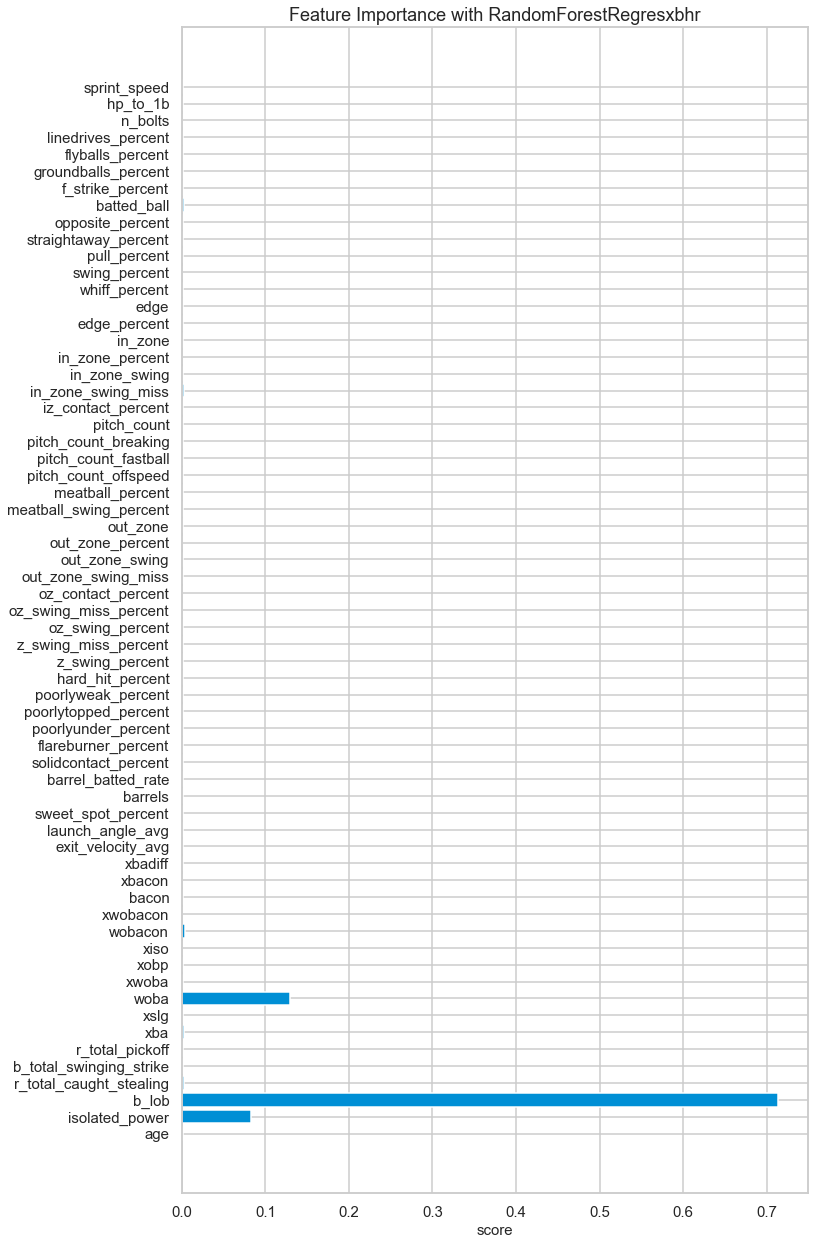

In [71]:
#plot for a better view
plt.figure(figsize=(10,20));
plt.barh(X_train_ops.columns, rf_important);
plt.title("Feature Importance with RandomForestRegresopsr")
plt.xlabel("score",fontsize = 15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

### Machine Learning

In [ ]:
pipe = Pipeline([
        ('RF', print("ops RF R2 of the 5 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (RandomForestRegresopsr
                                                              (random_state=42 , n_jobs= 6), 
                                                              X_train_ops, y_train_ops, cv=5, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("ops XGboost R2 of the 5 folds = {}".format(np.mean
                                                                       (cross_val_score
                                                                        (xgboost.XGBRegresopsr
                                                                         (objective="reg:squarederror", random_state=42, n_jobs= 6),
                                                                         X_train_ops, y_train_ops, cv=5, scoring = 'r2')
                                                                       )
                                                                      )
                          )
        ),
])

### XGBoost without PCA

In [47]:
from sklearn.model_selection import RandomizedSearchCV

XG_pipe = Pipeline(steps = [ ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_estimator.fit(X_train_ops, y_train_ops)
print("Randomized Search Finished")

Randomized Search Finished


In [48]:
XG_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9147206590270359,
                              gamma=0.004450353481010028, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.08359371085793546,
                              max_delta_step=0, max_depth=11,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=151,
                              n_jobs=0, num_parallel_tree=1, random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.5762815473653052, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [49]:
XGboost = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.9147206590270359, 
                               gamma = 0.004450353481010028, 
                               learning_rate = 0.08359371085793546, 
                               max_depth = 11, 
                               n_estimators = 151, 
                               subsample = 0.5762815473653052, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost.fit(X_train_ops,y_train_ops)

XG_ops_predictions = XGboost.predict(X_test_ops)

In [50]:
r2_score_xgboost = r2_score(y_test_ops, 
                             XG_ops_predictions)
r2_score_xgboost

0.9811035677822172

### XGBoost with PCA

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

XG_pipe = Pipeline(steps = [ ('pca', PCA() ), ('XGBoost', xgboost.XGBRegressor(objective="reg:squarederror", random_state=42,)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8),
}
# Create a grid search to try all the possible number of PCs
XG_PCA_estimator = RandomizedSearchCV(XG_pipe, 
                               params, 
                               cv=5, 
                               n_iter=200, 
                               n_jobs=-1, 
                               scoring = 'r2' ) 

XG_PCA_estimator.fit(X_train_ops, y_train_ops)
print("Randomized Search Finished")

Randomized Search Finished


In [52]:
XG_PCA_estimator.best_estimator_

Pipeline(steps=[('pca', PCA()),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8746886334812017,
                              gamma=0.023452098564332502, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.16841460142522408,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=416, n_jobs=0, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.685546751331908,
                              tree_method='exact', validate_parameters=1,
                              verbo

In [53]:
XGboost_PCA = xgboost.XGBRegressor(objective= 'reg:squarederror' , 
                               colsample_bytree = 0.8746886334812017, 
                               gamma = 0.023452098564332502, 
                               learning_rate = 0.16841460142522408, 
                               max_depth = 3, 
                               n_estimators = 416, 
                               subsample = 0.685546751331908, 
                               random_state=42, 
                               n_jobs= 0,) # add optimal hyperparameter values 
XGboost_PCA.fit(X_train_ops,y_train_ops)

PCA_ops_predictions = XGboost_PCA.predict(X_test_ops)

In [54]:
r2_score_xgboost = r2_score(y_test_ops, 
                             PCA_ops_predictions)
r2_score_xgboost

0.9722862266076636

### Export your best model

In [55]:
PCA_ops_predictions = pd.DataFrame(PCA_ops_predictions)

In [56]:
PCA_ops_predictions = PCA_ops_predictions.join(names_df, how="inner")

In [57]:
PCA_ops_predictions = PCA_ops_predictions.pivot_table(index="name")
PCA_ops_predictions.head()

,0
name,
Abreu Jose,0.804220
Acuna Jr. Ronald,0.869538
Adames Willy,0.723607
Adams Matt,0.714265
Adrianza Ehire,0.752794


In [58]:
XG_ops_predictions = pd.DataFrame(XG_ops_predictions)

In [59]:
XG_ops_predictions = XG_ops_predictions.join(names_df, how="inner")

In [60]:
XG_ops_predictions = XG_ops_predictions.pivot_table(index="name")
XG_ops_predictions.head()

,0
name,
Abreu Jose,0.814272
Acuna Jr. Ronald,0.870661
Adames Willy,0.724212
Adams Matt,0.714308
Adrianza Ehire,0.754378


Lets use the PCA one, I like the results more and it seems to be overfitting less.

In [89]:
PCA_ops_predictions.to_csv("ops.csv")

In [61]:
XG_ops_predictions.to_csv("ops.csv")

## Visualizations for insights

In [ ]:
trace0 = go.Box(
    # Data for paid apps
    y=apps[apps['Type'] == "Paid"]['Installs'],
    name = 'Paid'
)

trace1 = go.Box(
    # Data for free apps
    y=apps[apps['Type'] == "Free"]['Installs'],
    name = 'Free'
)

layout = go.Layout(
    title = "Number of downloads of paid apps vs. free apps",
    yaxis = dict(
        type = 'log',
        autorange = True
    )
)

# Add trace0 and trace1 to a list for plotting
data = [trace0,trace1]
plotly.offline.iplot({'data': data, 'layout': layout})